## Browse DKRZ catalog on Levante HPC system

Search for LUMIP simulations and available models

In [1]:
import os
import glob

import math
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import seaborn as sns

import numpy as np
import xarray as xr
import cftime
import pandas as pd

In [2]:
work = "locale" # or "levante"

if work == "levante":
    data_path = "/home/m/m301093/data/clean/"
    out_path = "/home/m/m301093/results_biophys/"
else:
    data_path = "G:/My Drive/MPIM/data/"
    out_path = "G:/My Drive/MPIM/Figures/"


## Functions

In [3]:
def xr_multimodel_sign(xr_in, models):
    # Computes the Multimodel MEAN and STD
    # xr_in: list of xarray models
    mm = xr.concat(xr_in, dim = "esm", coords = "minimal", compat = "override")
    
    std = xr.concat(xr_in, dim = "esm", coords = "minimal", compat = "override").std(dim = "esm")
    
    # Multimodel agreement in the sign of the sensitivity
    sign = xr.where(mm > 0, 1, -1)
    agreement = (np.abs(sign.sum(dim = "esm")/len(models)))
    
    mean = mm.mean(dim = "esm")
    return (mean, std, agreement)

In [4]:
def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

In [5]:
#### --------- Mann-Whitney Test --------- ####
from scipy.stats import mannwhitneyu

# Test applied on a grid-cell basis. For every gid-cell, the statistical difference between two time series is computed.
# 1st time series: Nino years' (DS_models_hist_nino)
# 2nd time series: Reference climatology (DS_models_hist_clim or DS_models_hist_clim_neutral)  

## -- Function for grid-cell operations -- ##
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)


def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [6]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    results = {}
    results["cor"] = cor
    results["coef"] = slope
    results["pval"] = pval
    return results

## Import preprocessed data

In [7]:
models = [ "ACCESS-ESM1-5", "CanESM5", "IPSL-CM6A-LR", "MPI-ESM1-2-LR", "UKESM1-0-LL", ]

In [8]:
scenario = 'ssp126Lu'
xr_aff = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_aff.append(content)


scenario = 'ssp370'
xr_ctl = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_ctl.append(content)


In [9]:
scenario = 'ssp126Lu'
xr_aff_pft = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_aff_pft.append(content)


scenario = 'ssp370'
xr_ctl_pft = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_ctl_pft.append(content)


### Preprocessing

In [10]:
# CanESM5 does not provide Latent Heat
# We derive it as Rn - H (ignoring Ground Heat fluxes that are negligible over land)

xr_ctl[1]["hfls"] = (xr_ctl[1].rsds - xr_ctl[1].rlds) - xr_ctl[1].hfss
xr_aff[1]["hfls"] = (xr_aff[1].rsds - xr_aff[1].rlds) - xr_aff[1].hfss

# Rename ta to tas 
xr_aff[1] = xr_aff[1].rename({"ta":"tas"})
xr_ctl[1] = xr_ctl[1].rename({"ta":"tas"})

# Select the first pressure level
xr_aff[1] = xr_aff[1].isel(plev = 0)
xr_ctl[1] = xr_ctl[1].isel(plev = 0)

# Try to interpolate surface temperature for CanESM5
xr_ctl[1]["tas"] = (xr_ctl[1].ts + xr_ctl[1].tas)/2
xr_aff[1]["tas"] = (xr_aff[1].ts + xr_aff[1].tas)/2


In [11]:
# Convert pr and evspsbl from kg m-2 s-1 to mm month-1
for i,mm in enumerate(models):
    xr_ctl[i]["pr"] = xr_ctl[i].pr*86400* xr_ctl[i].time.dt.days_in_month
    xr_aff[i]["pr"] = xr_aff[i].pr*86400* xr_aff[i].time.dt.days_in_month
    
    xr_ctl[i]["pr"].attrs=dict(units="mm/months")
    xr_aff[i]["pr"].attrs=dict(units="mm/months")

    xr_ctl[i]["evspsbl"] = xr_ctl[i].evspsbl*86400* xr_ctl[i].time.dt.days_in_month
    xr_aff[i]["evspsbl"] = xr_aff[i].evspsbl*86400* xr_aff[i].time.dt.days_in_month
    
    xr_ctl[i]["evspsbl"].attrs=dict(units="mm/months")
    xr_aff[i]["evspsbl"].attrs=dict(units="mm/months")
    
    xr_aff[i]["albedo"] = xr_aff[i].rsus / xr_aff[i].rsds
    xr_ctl[i]["albedo"] = xr_ctl[i].rsus / xr_ctl[i].rsds
    
    

### Afforestation and regime masking

In [12]:
xr_delta = []
xr_delta_pft = []
for i,mm in enumerate(models):
    xr_delta.append(xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time"))
    xr_delta_pft.append(xr_aff_pft[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl_pft[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time"))

In [13]:
%%capture

# masking regions of treefrac increase or decrease
mask_treefrac_pos = []
mask_treefrac_neg = []

for m,_ in enumerate(models):
    # identify regions with 5%+ and 5%- treefrac
    mask_treefrac_pos.append(xr_delta_pft[m]["treeFrac"].where(xr_delta_pft[m]["treeFrac"] > 10))
    mask_treefrac_neg.append(xr_delta_pft[m]["treeFrac"].where(xr_delta_pft[m]["treeFrac"] <- 10))


In [14]:
def get_pixel_area(lat, lon):
    """Calculate the area of each pixel in m^2 given latitudes and longitudes."""
    # Earth radius in meters
    R = 6.371e6
    rad = (2 * math.pi / 360)  # Convert degrees to radians

    # Reshape lat and lon to make sure they have the correct shape
    if lat[0] > lat[-1]:
        lat = lat[::-1]

    # Calculate the area of each pixel
    pixel_areas = np.zeros((len(lat) - 1, len(lon) - 1))
    for i in range(len(lat) - 1):
        for j in range(len(lon) - 1):
            pixel_areas[i, j] = (2 * math.pi * R ** 2 *
                                 (math.sin(rad * lat[i + 1]) - math.sin(rad * lat[i])) *
                                 abs(lon[j + 1] - lon[j]) * rad)
    return pixel_areas

for m,mm in enumerate(models):
    mask_lat = mask_treefrac_pos[m].lat.values
    mask_lon = mask_treefrac_pos[m].lon.values

    # Get the pixel area for the mask's lat/lon grid
    pixel_areas = get_pixel_area(mask_lat, mask_lon)

    # Ensure pixel_areas has the same dimensions as the mask
    pixel_areas = xr.DataArray(pixel_areas, coords=[mask_lat[:-1], mask_lon[:-1]], dims=["lat", "lon"])

    # Mask the pixel areas
    masked_areas = pixel_areas.where(~np.isnan(mask_treefrac_pos[m]))

    # Calculate the total area
    total_area = masked_areas.sum().values

    # Convert from m^2 to Mkm^2
    total_area_km2 = total_area / 1e12

    print("Area of Delta_treefrac > 10% for " + mm + ": " + str(total_area_km2.round(0)) + " Mkm²")

Area of Delta_treefrac > 10% for ACCESS-ESM1-5: 79.0 Mkm²
Area of Delta_treefrac > 10% for CanESM5: 79.0 Mkm²
Area of Delta_treefrac > 10% for IPSL-CM6A-LR: 107.0 Mkm²
Area of Delta_treefrac > 10% for MPI-ESM1-2-LR: 98.0 Mkm²
Area of Delta_treefrac > 10% for UKESM1-0-LL: 75.0 Mkm²


78.9

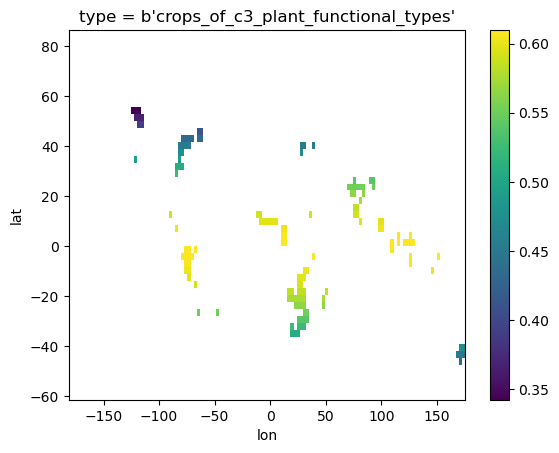

In [15]:

mask_lat = mask_treefrac_pos[1].lat.values
mask_lon = mask_treefrac_pos[1].lon.values

# Get the pixel area for the mask's lat/lon grid
pixel_areas = get_pixel_area(mask_lat, mask_lon)
pixel_areas = xr.DataArray(pixel_areas, coords=[mask_lat[:-1], mask_lon[:-1]], dims=["lat", "lon"])
masked_areas = pixel_areas.where(~np.isnan(mask_treefrac_pos[1])) / 1e12
masked_areas.plot()
np.nansum(masked_areas.values).round(1)

In [39]:
def regime_limit(dataset):
    cor_pr = lag_linregress_3D(dataset['hfls'], dataset['pr'])['cor'].compute()
    cor_ts = lag_linregress_3D(dataset['hfls'], dataset['ts'])['cor'].compute()
    
    water_limited = dataset.sel(time = -1).where(cor_pr > cor_ts, drop=False)["lai"]
    energy_limited = dataset.isel(time = -1).where(cor_pr < cor_ts, drop=False)["lai"]
    
    # Ensure computation and time slice selection
    return water_limited, energy_limited

In [40]:
mask_aff_water = []
mask_aff_energy = []
mask_ctl_water = []
mask_ctl_energy = []
for m, mm in enumerate(models):
    water, energy = regime_limit(xr_aff[m].sel(time = slice("2071-01","2100-12")))
    mask_aff_water.append(water)
    mask_aff_energy.append(energy)
    
    water, energy = regime_limit(xr_ctl[m].sel(time = slice("2071-01","2100-12")))
    mask_ctl_water.append(water)
    mask_ctl_energy.append(energy)

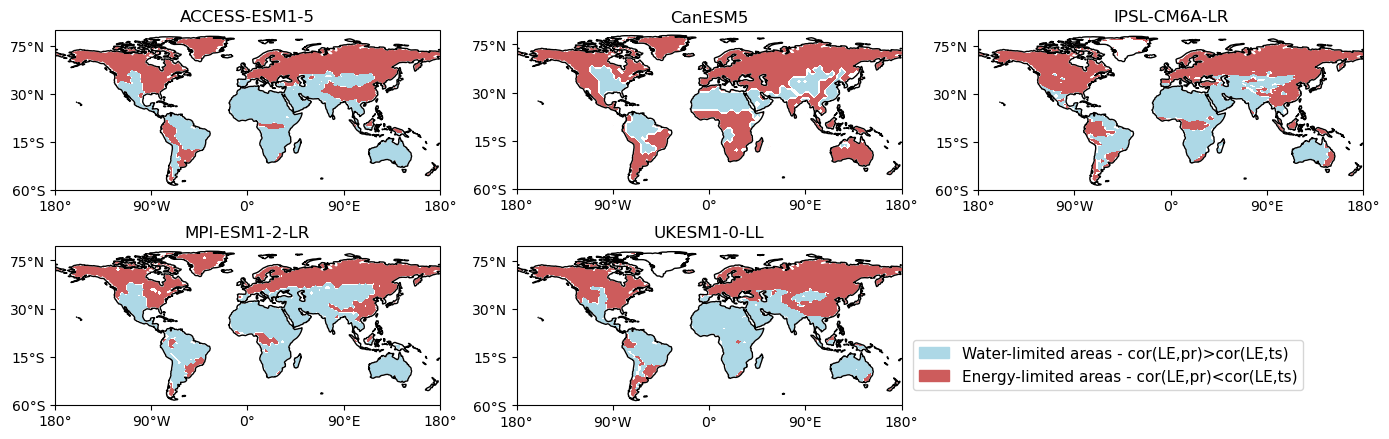

In [55]:
import matplotlib.patches as mpatches

water_patch = mpatches.Patch(color='lightblue', label='Water-limited areas - cor(LE,pr)>cor(LE,ts)')
energy_patch = mpatches.Patch(color='indianred', label='Energy-limited areas - cor(LE,pr)<cor(LE,ts)')

width_inch = 14
height_inch = 6

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()
for i,_ in enumerate(models):
    
    data = mask_aff_water[i].isel(time = -1)
    lats = data.lat
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])

    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), colors="lightblue")

    data = mask_aff_energy[i].isel(time = -1)  
    lats = data.lat
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])
    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), colors = "indianred")

    axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
    # Set subplot title
    axs[i].set_title(models[i])

# # Delete the unwanted axes
for i in [5]:
    fig.delaxes(axs[i])
        
fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)
fig.tight_layout()

# Add the legend
fig.legend(handles=[water_patch, energy_patch], loc='lower right', bbox_to_anchor=(0.94, 0.2), ncol=1, fontsize = 11)

title = "delta_treeFrac_ssp370_esm"
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

### treeFrac change

SSP370

/tmp/ipykernel_3241970/2286709777.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


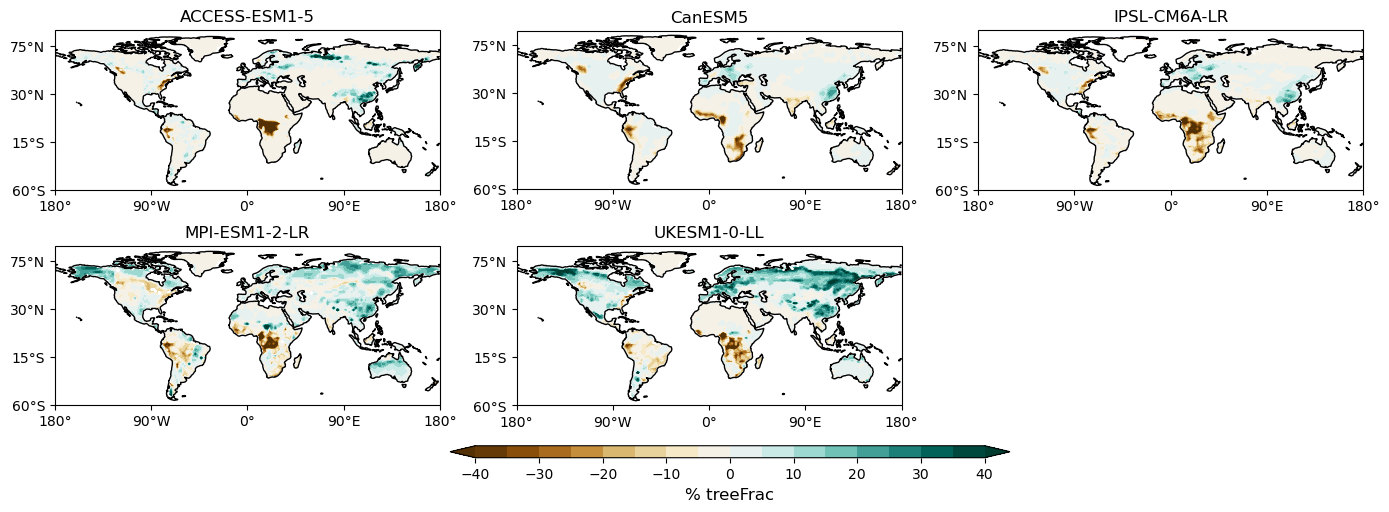

In [ ]:
## luc_rate = luc_rate.sel(lat = slice(-60,90))
# luc_rate = luc_rate - luc_rate.isel(time = 0)

vars_plot = "treeFrac"
cmap = "BrBG"
clevs=np.arange(-40,41,5)

width_inch = 14
height_inch = 6

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()
for i,_ in enumerate(models):
    
    data = (xr_ctl_pft[i].isel(time = -1).treeFrac - xr_ctl_pft[i].isel(time = 0).treeFrac)   # data = to_plot[1].isel(time = -1)[vv]
    lats = data.lat
        
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])

    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), cmap=cmap,extend='both')
    axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
    # Set subplot title
    axs[i].set_title(models[i])

# # Delete the unwanted axes
for i in [5]:
    fig.delaxes(axs[i])
        
fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)  
cbar.ax.set_xlabel("% treeFrac", fontsize=12)

fig.tight_layout()

title = "delta_treeFrac_ssp370_esm"
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

ssp126

/tmp/ipykernel_3241970/4100250727.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


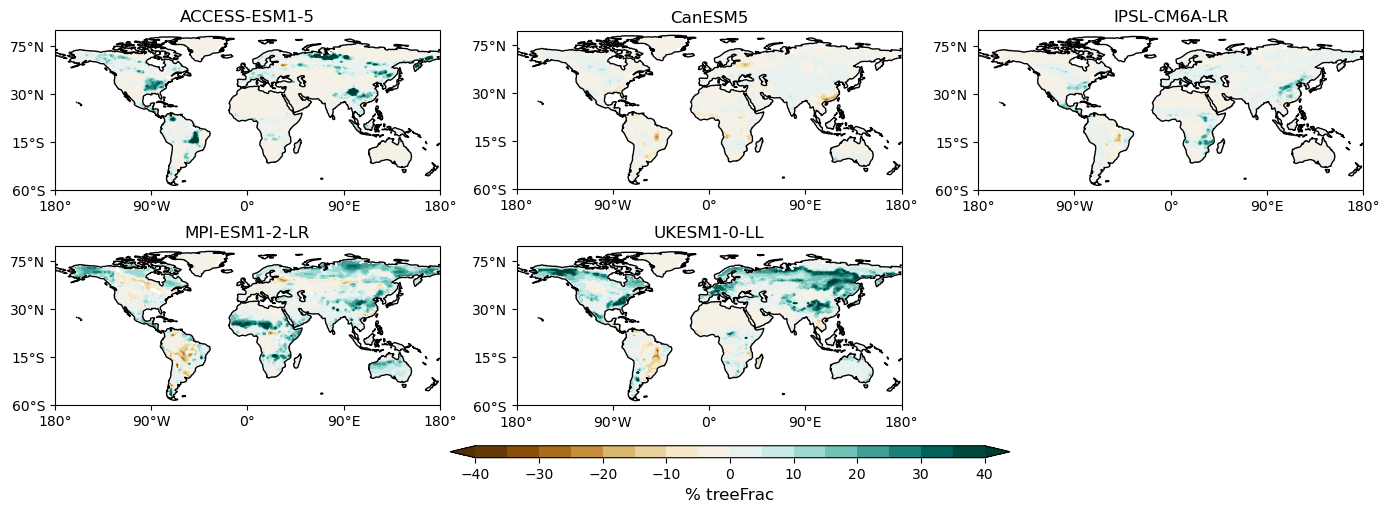

In [ ]:
## luc_rate = luc_rate.sel(lat = slice(-60,90))
# luc_rate = luc_rate - luc_rate.isel(time = 0)

vars_plot = "treeFrac"
cmap = "BrBG"
clevs=np.arange(-40,41,5)

width_inch = 14
height_inch = 6

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()
for i,_ in enumerate(models):
    
    data = (xr_aff_pft[i].isel(time = -1).treeFrac - xr_aff_pft[i].isel(time = 0).treeFrac)   # data = to_plot[1].isel(time = -1)[vv]
    lats = data.lat
        
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])

    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), cmap=cmap,extend='both')
    axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
    # Set subplot title
    axs[i].set_title(models[i])

# # Delete the unwanted axes
for i in [5]:
    fig.delaxes(axs[i])
        
fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)  
cbar.ax.set_xlabel("% treeFrac", fontsize=12)

fig.tight_layout()

title = "delta_treeFrac_ssp126_esm"
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

/tmp/ipykernel_3241970/3431707365.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


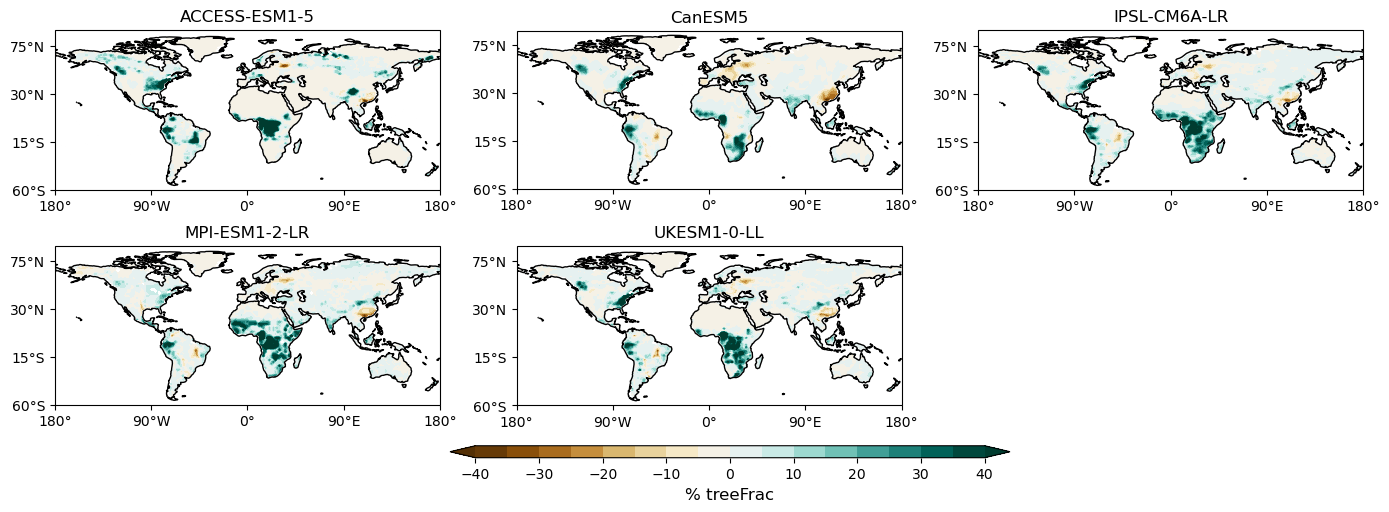

In [ ]:
## luc_rate = luc_rate.sel(lat = slice(-60,90))
# luc_rate = luc_rate - luc_rate.isel(time = 0)

vars_plot = "treeFrac"
cmap = "BrBG"
clevs=np.arange(-40,41,5)

width_inch = 14
height_inch = 6

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()
for i,_ in enumerate(models):
    
    data = (xr_aff_pft[i].isel(time = -1).treeFrac - xr_ctl_pft[i].isel(time = -1).treeFrac)    # data = to_plot[1].isel(time = -1)[vv]
    lats = data.lat
        
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])

    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), cmap=cmap,extend='both')
    axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
    # Set subplot title
    axs[i].set_title(models[i])

# # Delete the unwanted axes
for i in [5]:
    fig.delaxes(axs[i])
        
fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)  
cbar.ax.set_xlabel("% treeFrac", fontsize=12)

fig.tight_layout()

title = "delta_treeFrac_esm"
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

## Temperature response

Test the significance with Mann-Whitney U test

In [21]:
import xarray as xr

xr_mw_ts = []
for i,mm in enumerate(models):
    
    mw = multi_apply_along_axis(mannwhitneyu, 0, [xr_aff[i].sel(time = slice("2071-01","2100-12")).ts.fillna(0), 
                                                  xr_ctl[i].sel(time = slice("2071-01","2100-12")).ts.fillna(0)])[1]
    mw_xr = xr.DataArray(mw, dims=["lat","lon"], coords=dict(lon = (xr_aff[i].lon.values), lat= (xr_ctl[i].lat.values)))
    
    xr_mw_ts.append(mw_xr)
    

/tmp/ipykernel_3241970/4144499788.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


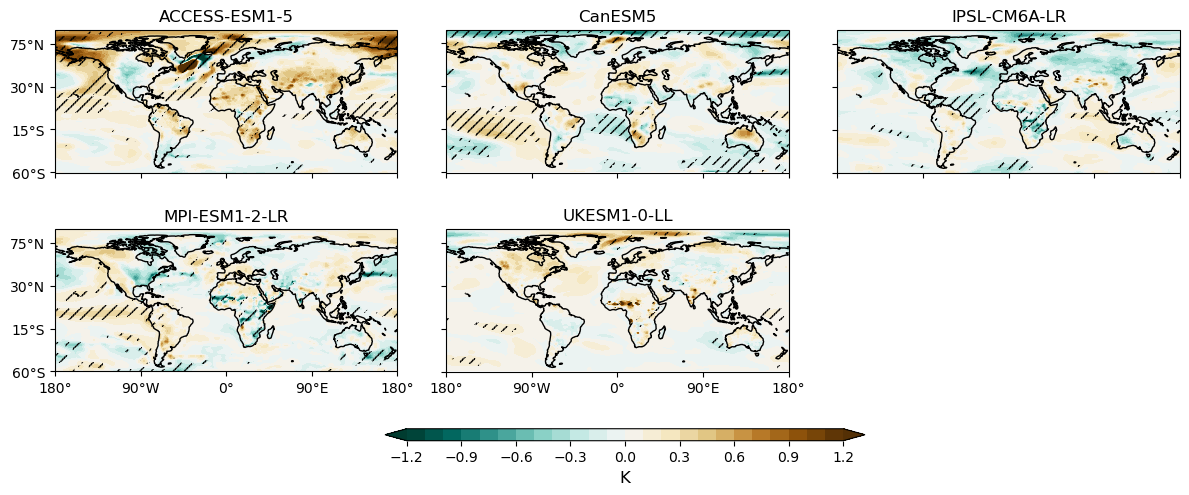

In [18]:
# luc_rate = luc_rate.sel(lat = slice(-60,90))
# luc_rate = luc_rate - luc_rate.isel(time = 0)

cmap = "BrBG_r"
clevs=np.arange(-1.2,1.3,0.1)

width_inch = 12
height_inch = 6

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()
for i in np.arange(len(models)):
    
    data = (xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time").ts - 
            xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time").ts)
    lats = data.lat
    
    hatch = xr_mw_ts[i]
    
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])

    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), cmap=cmap,extend='both')
    # axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    
    sign = np.ma.masked_greater(hatch, 0.1)
    map1 = axs[i].pcolor(lons, lats, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha=0)
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
    # Set subplot title
    axs[i].set_title(models[i])
    
    axs[i].label_outer()
    
for i in [5]:
    fig.delaxes(axs[i])
        

fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)  
cbar.ax.set_xlabel("K", fontsize=12)

fig.tight_layout()

title = "Ts_esm_mw_0.1"
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

### Ts in regions of Afforestation

In [87]:
ts_aff_water_mean = []
ts_aff_energy_mean = []
ts_aff_mw = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull()
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull()
    mask2 = mask_treefrac_pos[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask

    data = (xr_aff[m].sel(time = slice("2071-01","2100-12")).mean(dim = "time").ts - 
            xr_ctl[m].sel(time = slice("2071-01","2100-12")).mean(dim = "time").ts)
    
    masked = data.where(mask)
    masked1 = data.where(mask1)
    masked2 = data.where(mask2)

    print("% of afforestation cells with significant Ts difference: " + mm + " " + str((masked2.count().values.sum()/mask_treefrac_pos[m].count().values.sum()*100).round(0)) + "%")

    content = np.array(masked.weighted(cell_weight(masked)).mean(["lat","lon"]).values)
    content1 = np.array(masked1.weighted(cell_weight(masked1)).mean(["lat","lon"]).values)
    content2 = np.array(masked2.weighted(cell_weight(masked2)).mean(["lat","lon"]).values)

    ts_aff_water_mean.append(content) 
    ts_aff_energy_mean.append(content1)
    ts_aff_mw.append(content2)

    
ts_aff_water_mean = pd.DataFrame(ts_aff_water_mean, index = models)
ts_aff_energy_mean = pd.DataFrame(ts_aff_energy_mean, index = models)
ts_aff_mw = pd.DataFrame(ts_aff_mw, index = models)

% of afforestation cells with significant Ts difference: ACCESS-ESM1-5 23.0%
% of afforestation cells with significant Ts difference: CanESM5 16.0%
% of afforestation cells with significant Ts difference: IPSL-CM6A-LR 37.0%
% of afforestation cells with significant Ts difference: MPI-ESM1-2-LR 49.0%
% of afforestation cells with significant Ts difference: UKESM1-0-LL 6.0%


In [88]:
ts_aff_water_mean["regime"] = "water-lim"
ts_aff_energy_mean["regime"] = "energy-lim"

ts_aff = pd.concat([ts_aff_water_mean, ts_aff_energy_mean], axis = 0)
ts_aff.columns = ["value", "regime"]
ts_aff = ts_aff.reset_index().rename(columns = {"index":"models"})
ts_aff_mean = ts_aff.groupby(['models'])['value'].mean().reset_index()

ts_aff_mw = ts_aff_mw.reset_index().rename(columns = {"index":"models"})
ts_aff_mw.columns = ["models", "value"]

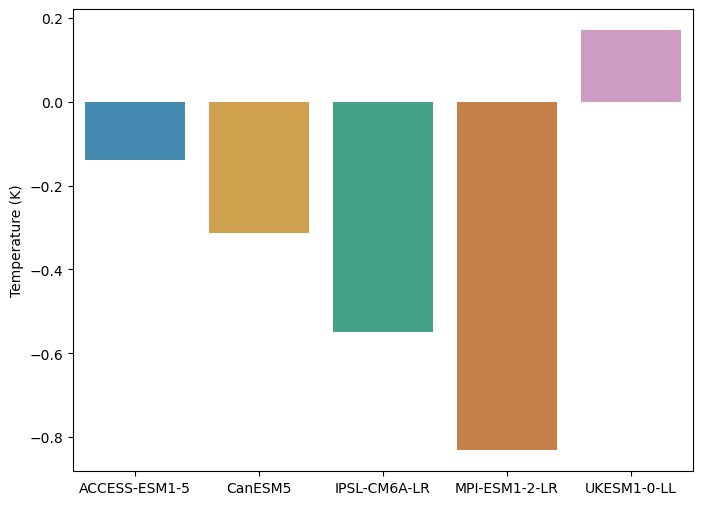

In [90]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=ts_aff_mw, # errorbar=("pi", 50),
        x="models", y="value",palette="colorblind",
       alpha=.8,
    )
# ax0.set_xticklabels(vars, rotation = 75)
# ax0.set_ylim(-0.45, 0.1)
# ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("Temperature (K)")
title = "Temperature response in afforested regions (treeFrac>10%)"
# ax0.set_title(title)
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

In [91]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]
Ts_regions_esm = []
for m,mm in enumerate(models):
    content_pos = []
    content_neg = []

    data = (xr_aff[m].sel(time = slice("2071-01","2100-12")).mean(dim = "time").ts - 
            xr_ctl[m].sel(time = slice("2071-01","2100-12")).mean(dim = "time").ts)

    for b in boxes:
        # np.ma.masked_less(xr_mw_ts[m], 0.1).mask to consider the significative
        masked = data.where(mask_treefrac_pos[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3]))
        content_pos.append(masked.weighted(cell_weight(masked)).mean().compute().data)
        
    Ts_regions_esm.append(pd.DataFrame(content_pos))


Ts_regions_esm = pd.concat(Ts_regions_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
Ts_regions_esm["regions"] = Ts_regions_esm.index
Ts_regions_esm = pd.melt(Ts_regions_esm, id_vars="regions", var_name="esm")

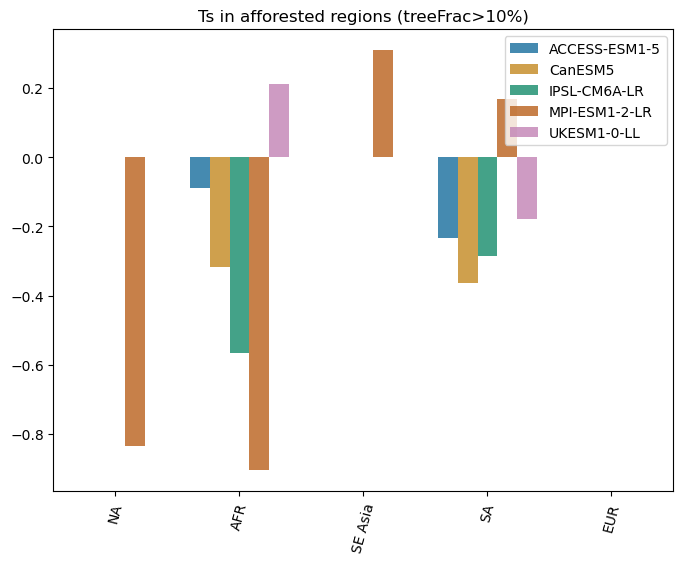

In [93]:
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=Ts_regions_esm.sort_values("esm"), hue = "esm",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.8, 
    )
ax0.set_xticklabels(regions, rotation = 75)
# ax0.set_ylim(-0.25, 0.25)
ax0.legend(loc='upper right', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("")
title = "Ts in afforested regions (treeFrac>10%)"
ax0.set_title(title)
output_file = os.path.join(out_path, title) + "_Regional.png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()


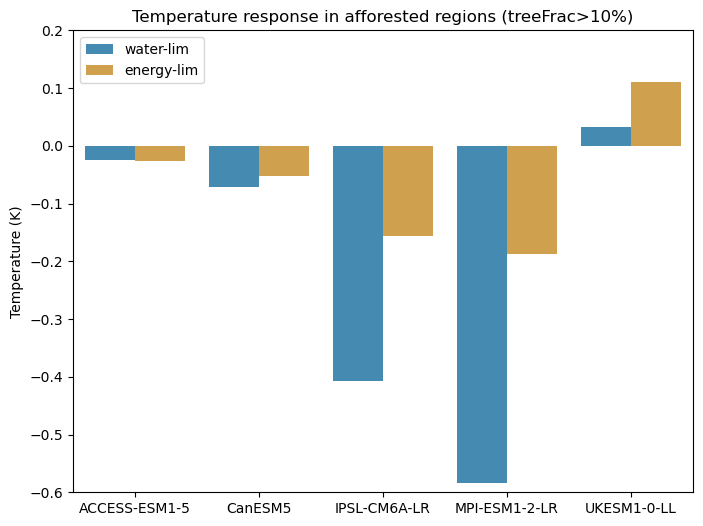

In [133]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=ts_aff.sort_values("models"), hue = "regime",# errorbar=("pi", 50),
        x="models", y="value",
        palette="colorblind", alpha=.8, 
    )
# ax0.set_xticklabels(vars, rotation = 75)
ax0.set_ylim(-0.6, 0.2)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("Temperature (K)")
title = "Temperature response in afforested regions (treeFrac>10%)"
ax0.set_title(title)
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

### dTS/dtreeFrac & cor(Ts,treeFrac)

In [58]:
%%capture
dts_aff_water_mean = []
dts_aff_energy_mean = []
dts_aff_mw = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask
    mask2 = mask_treefrac_pos[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask

    data = lag_linregress_3D((xr_aff[m].ts - xr_ctl[m].ts), (xr_aff_pft[m]["treeFrac"] - xr_ctl_pft[m]["treeFrac"]))["cor"]
    
    masked = data.where(mask)
    masked1 = data.where(mask1)
    masked2 = data.where(mask2)

    content = np.array(masked.weighted(cell_weight(masked)).mean(["lat","lon"]).values)
    content1 = np.array(masked1.weighted(cell_weight(masked1)).mean(["lat","lon"]).values)
    content2 = np.array(masked2.weighted(cell_weight(masked2)).mean(["lat","lon"]).values)

    dts_aff_water_mean.append(content); 
    dts_aff_energy_mean.append(content1);
    dts_aff_mw.append(content2)
    
dts_aff_water_mean = pd.DataFrame(dts_aff_water_mean, index = models)
dts_aff_energy_mean = pd.DataFrame(dts_aff_energy_mean, index = models)
dts_aff_mw = pd.DataFrame(dts_aff_mw, index = models)

In [59]:
dts_aff_water_mean["regime"] = "water-lim"
dts_aff_energy_mean["regime"] = "energy-lim"

dts_aff = pd.concat([dts_aff_water_mean, dts_aff_energy_mean], axis = 0)
dts_aff.columns = ["value", "regime"]
dts_aff = dts_aff.reset_index().rename(columns = {"index":"esm"})
dts_aff_mean = dts_aff.groupby(['esm'])['value'].mean().reset_index()
dts_aff_mw = dts_aff_mw.reset_index().rename(columns = {"index":"esm"})
dts_aff_mw.columns = ["esm", "value"]
dts_aff_mw["regions"] = "globe"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


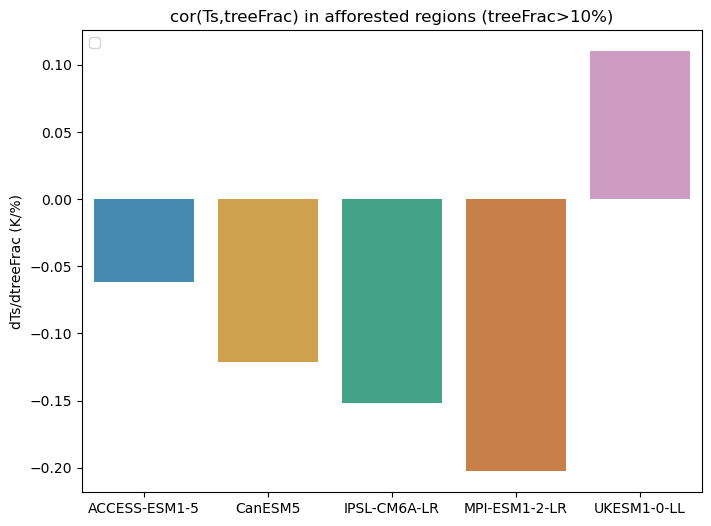

In [54]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=dts_aff_mw.sort_values("models"),# errorbar=("pi", 50),
        x="models", y="values",
        palette="colorblind", alpha=.8, 
    )
# ax0.set_xticklabels(vars, rotation = 75)
# ax0.set_ylim(-0.6, 0.2)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("dTs/dtreeFrac (K/%)")
title = "cor(Ts,treeFrac) in afforested regions (treeFrac>10%)"
ax0.set_title(title)
output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

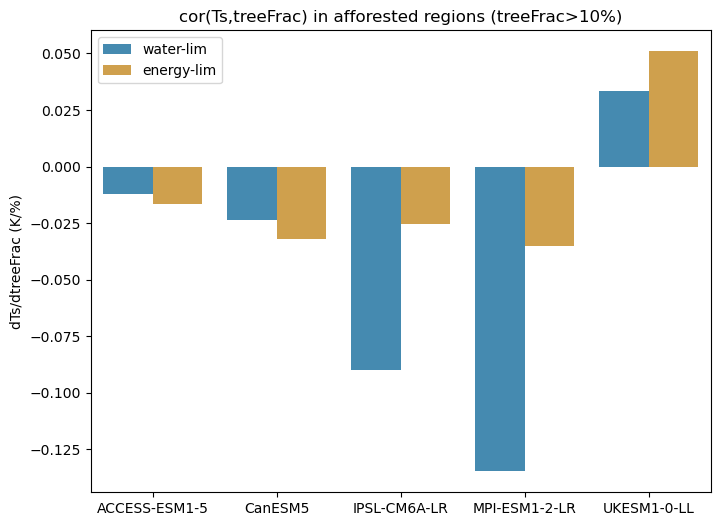

In [146]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=dts_aff.sort_values("models"), hue = "regime",# errorbar=("pi", 50),
        x="models", y="value",
        palette="colorblind", alpha=.8, 
    )
# ax0.set_xticklabels(vars, rotation = 75)
# ax0.set_ylim(-0.6, 0.2)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("dTs/dtreeFrac (K/%)")
title = "cor(Ts,treeFrac) in afforested regions (treeFrac>10%)"
ax0.set_title(title)
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

In [51]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]
corTs_tree_pos_esm = []
corTs_tree_neg_esm = []
for m,mm in enumerate(models):
    content_pos = []
    content_neg = []

    data = lag_linregress_3D((xr_aff[m].ts - xr_ctl[m].ts), (xr_aff_pft[m]["treeFrac"] - xr_ctl_pft[m]["treeFrac"]))["cor"]

    for b in boxes:
        # np.ma.masked_less(xr_mw_ts[m], 0.1).mask to consider the significative
        masked = data.where(mask_treefrac_pos[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3]))
        masked1 = data.where(mask_treefrac_neg[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3]))
        content_pos.append(masked.weighted(cell_weight(masked)).mean().compute().data)
        content_neg.append(masked1.weighted(cell_weight(masked1)).mean().compute().data)
        
    corTs_tree_pos_esm.append(pd.DataFrame(content_pos))
    corTs_tree_neg_esm.append(pd.DataFrame(content_neg))


corTs_tree_pos_esm = pd.concat(corTs_tree_pos_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
corTs_tree_neg_esm = pd.concat(corTs_tree_neg_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
corTs_tree_pos_esm["regions"] = corTs_tree_pos_esm.index
corTs_tree_neg_esm["regions"] = corTs_tree_neg_esm.index
corTs_tree_pos_esm = pd.melt(corTs_tree_pos_esm, id_vars="regions", var_name="esm")
corTs_tree_neg_esm = pd.melt(corTs_tree_neg_esm, id_vars="regions", var_name="esm")

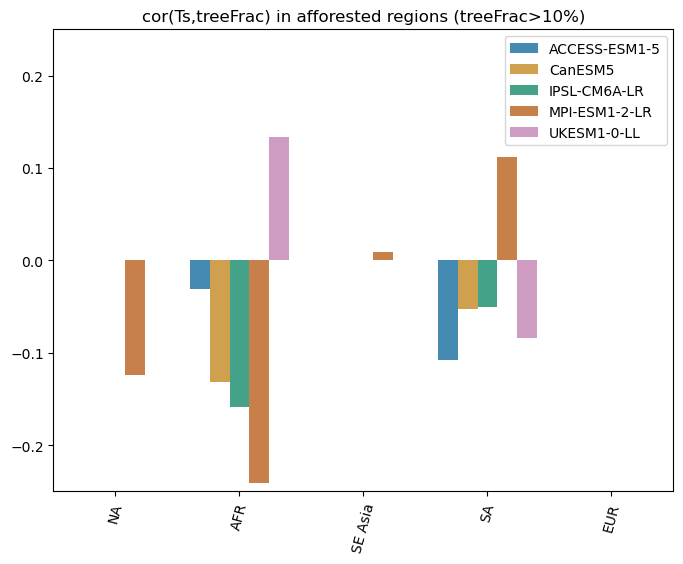

In [52]:
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=corTs_tree_pos_esm.sort_values("esm"), hue = "esm",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.8, 
    )
ax0.set_xticklabels(regions, rotation = 75)
ax0.set_ylim(-0.25, 0.25)
ax0.legend(loc='upper right', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("")
title = "cor(Ts,treeFrac) in afforested regions (treeFrac>10%)"
ax0.set_title(title)
output_file = os.path.join(out_path, title) + "_Regional.png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()


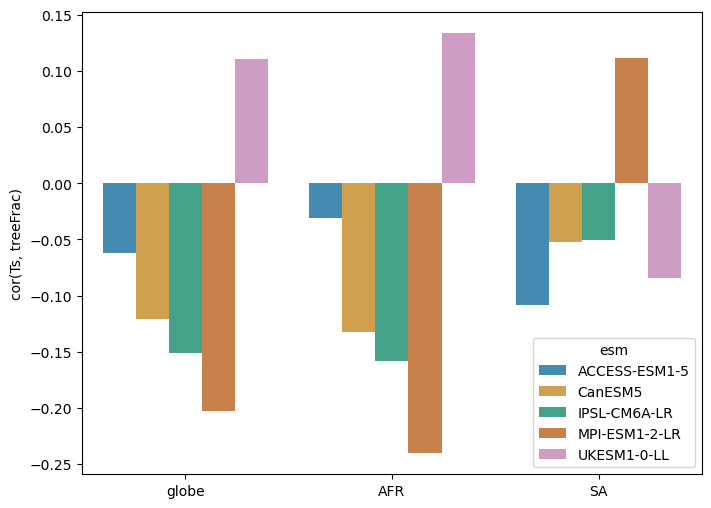

In [84]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))

custom_order = ['globe', 'AFR', 'SA']
data = pd.concat([corTs_tree_pos_esm, dts_aff_mw], axis = 0)
data = data[data['regions'].isin(custom_order)]
data['regions'] = pd.Categorical(data['regions'], categories=custom_order, ordered=True)
data = data.sort_values('regions')

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=data, hue = "esm", # errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.8,
    )
# ax0.set_xticklabels(vars, rotation = 75)
# ax0.set_ylim(-0.45, 0.1)
# ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("cor(Ts, treeFrac)")
title = "Temperature response in afforested regions (treeFrac>10%)"
# ax0.set_title(title)
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

## Surface Energy Balance (SEB) decomposition

Taking the difference between the biogeophysical variables of ssp370-ssp126 and ssp370 \
Compute the Surface Energy Balance Decomposition to estimate the contribution to temperature.

The SEB equation can be decomposed as follows:

\begin{equation}
\Delta T_{\text{s}} = \frac{1}{{4 \varepsilon \sigma T_{\text{s}}^3}_{\text{ssp370}}} \cdot (\Delta {SW_{net}} + \Delta LW_{in} - \Delta H - \Delta \lambda E - \Delta G)
\end{equation}

that by decomposing $\Delta {SW_{net}}$ becomes:

\begin{equation}
\Delta T_{\text{s}} = \frac{1}{{4 \varepsilon \sigma T_{\text{s}}^3}_{\text{ssp370}}} \cdot (-SW_{in}\Delta {\alpha_{s}} + (1-\alpha_{ssp370})\Delta SW_{in} + \Delta LW_{in} - \Delta H - \Delta \lambda E - \Delta G)
\end{equation}

we ignore surface emissivity changes.

In [33]:
# Define Stefan-Boltzmann Constant (Wm^-2K^-4)
# Define Emissivity Constant
# Define air density Constant (Kgm^-3) (dry air, 0°C, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6764509/)
# Define specific heat content (JKg^-1K^-1) (dry air, =0°C, https://pubs.aip.org/asa/jasa/article/76/2/555/669652/Variation-of-specific-heats-and-of-specific-heat)

sigma = 5.67*10**(-8)
eps = 0.97
rho = 1.2930
Cp = 1.0051*10**(3)

In [34]:
# Compute SEB on the last 30-yrs period (2071 - 2100)

dT_seb_esm = []
dT_model_esm = []
seb_effect_esm = []

for i,item in enumerate(xr_aff):
    seb_effects = xr.Dataset()

    xr_aff_seb = xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") # - xr_aff.sel(time = slice("2015-01","2015-12")).mean(dim = "time") 
    xr_ctl_seb = xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") # - xr_ctl.sel(time = slice("2015-01","2015-12")).mean(dim = "time") 

    factor = 1/(4*sigma*eps*xr_ctl_seb.ts**(3))

    Rn_aff = (xr_aff_seb.rsds - xr_aff_seb.rsus) + eps*xr_aff_seb.rlds - eps*sigma*xr_aff_seb.ts**(4)
    Rn_ctl = (xr_ctl_seb.rsds - xr_ctl_seb.rsus) + eps*xr_ctl_seb.rlds - eps*sigma*xr_ctl_seb.ts**(4)

    G_aff = Rn_aff - xr_aff_seb.hfss - xr_aff_seb.hfls
    G_ctl = Rn_ctl - xr_ctl_seb.hfss - xr_ctl_seb.hfls

    delta_Snet = factor * ((xr_aff_seb.rsds - xr_aff_seb.rsus) - (xr_ctl_seb.rsds - xr_ctl_seb.rsus))
    delta_Sd = factor * (xr_aff_seb.rsds - xr_ctl_seb.rsds) 
    delta_Ld = factor * (xr_aff_seb.rlds - xr_ctl_seb.rlds)
    delta_H = -factor * (xr_aff_seb.hfss - xr_ctl_seb.hfss)
    delta_LE = -factor * (xr_aff_seb.hfls - xr_ctl_seb.hfls)
    delta_albedo = -factor * ((xr_aff_seb.rsus/xr_aff_seb.rsds) - (xr_ctl_seb.rsus/xr_ctl_seb.rsds))

    deltaG = -factor * (G_aff - G_ctl)

    dT_seb = xr_ctl_seb.rsds*delta_albedo + (1-(xr_ctl_seb.rsus/xr_ctl_seb.rsds))*delta_Sd + delta_Ld + delta_H + delta_LE + deltaG
    dT_model = (xr_aff_seb.ts - xr_ctl_seb.ts)

    # seb_effects = [xr_ctl_seb.rsds*delta_albedo,
    #            (1-(xr_ctl_seb.rsus/xr_ctl_seb.rsds))*delta_Sd,
    #            delta_Ld,
    #            delta_H,
    #            delta_LE]
               # deltaG]
    seb_effects["albedo"] = xr_ctl_seb.rsds*delta_albedo
    seb_effects["Sd"] = (1-(xr_ctl_seb.rsus/xr_ctl_seb.rsds))*delta_Sd
    seb_effects["Ld"] = delta_Ld
    seb_effects["H"] = delta_H
    seb_effects["LE"] = delta_LE
    
    dT_seb_esm.append(dT_seb)
    dT_model_esm.append(dT_model)
    seb_effect_esm.append(seb_effects)
# Clean the xarray
# T_seb = T_seb.drop(labels = ["time_bnds","lat_bnds","lon_bnds"])
# T_model = T_model.drop(labels = ["time_bnds","lat_bnds","lon_bnds"])

/tmp/ipykernel_414914/4061411894.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


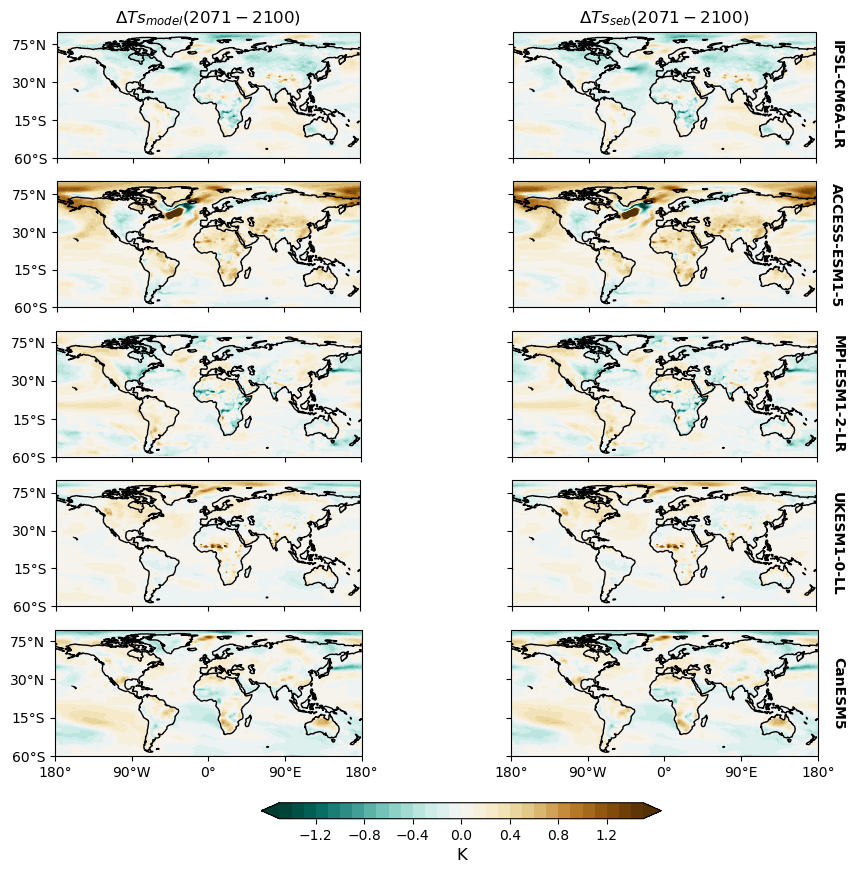

In [27]:
# Compare Temperature difference diagnosed from the model simulations (dT_model)
# with the one calculated from SEB decomposition (dT_seb)

# We can either plot the mean(2071-2100) or mean(2071-2100)-mean(2015) 

# dT_model = dT_model #.sel(time = slice("2071-01","2100-12")).mean(dim = "time") #- dT_model.sel(time = slice("2015-01","2015-12")).mean(dim = "time")
# dT_seb = dT_seb #.sel(time = slice("2071-01","2100-12")).mean(dim = "time") #- dT_seb.sel(time = slice("2015-01","2015-12")).mean(dim = "time")

to_plot = [dT_model_esm[0], dT_seb_esm[0], dT_model_esm[1], dT_seb_esm[1], dT_model_esm[2], dT_seb_esm[2], dT_model_esm[3], dT_seb_esm[3], dT_model_esm[4], dT_seb_esm[4]]

cmap = "BrBG_r"
clevs=np.arange(-1.5,1.6,0.1)

# Create the figure 
width_inch = 10
height_inch = 8

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.ravel()

for i, ax in enumerate(to_plot):
    
    # Add the cyclic point
    data = to_plot[i].sel(lat = slice(-60,90))
    data0,lons=add_cyclic_point(data,coord=data['lon'])
    
    map = axs[i].contourf(lons, data.lat, data0, clevs, transform = ccrs.PlateCarree(), cmap=cmap, extend='both')
    axs[i].coastlines()
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)    
    
    axs[0].set_title("$\Delta Ts_{model} (2071-2100)$")
    axs[1].set_title("$\Delta Ts_{seb} (2071-2100)$")
    
    if i%2 != 0: 
        idx = int((i/2)-0.5)
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel(models[idx], labelpad = 20, rotation = -90, weight='bold')
    
    axs[i].label_outer()
    
cb_ax = fig.add_axes([0.325, -0.03, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.1)
cbar.ax.set_xlabel("K", fontsize=12)

fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()

title = "SEB_Ts_esm"
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()


#### Disentangle the different contribution of SEB factors

In [49]:
vars = ["albedo", "Sd", "Ld", "H", "LE"]

/tmp/ipykernel_414914/169844593.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


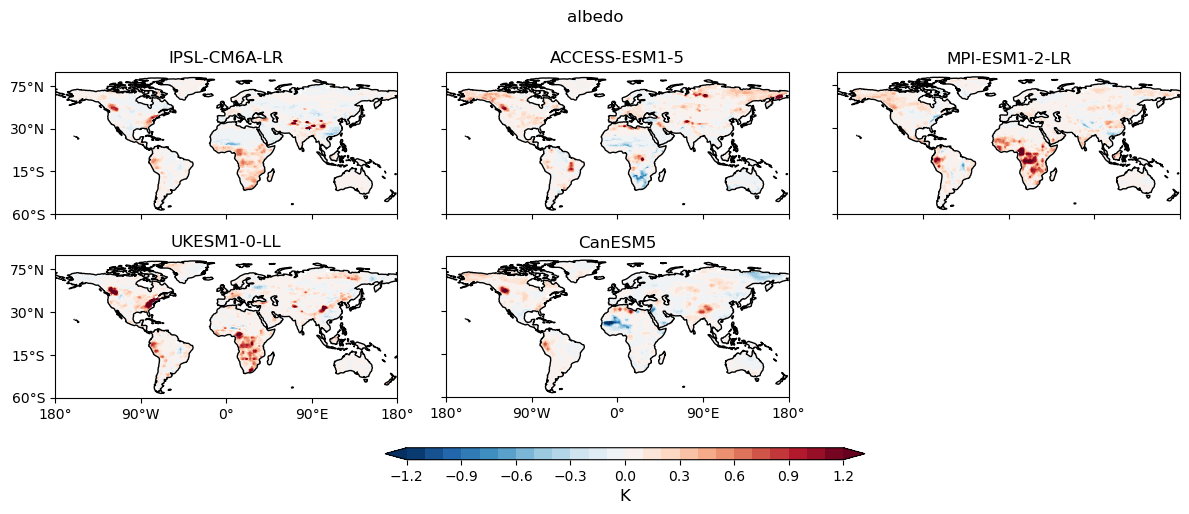

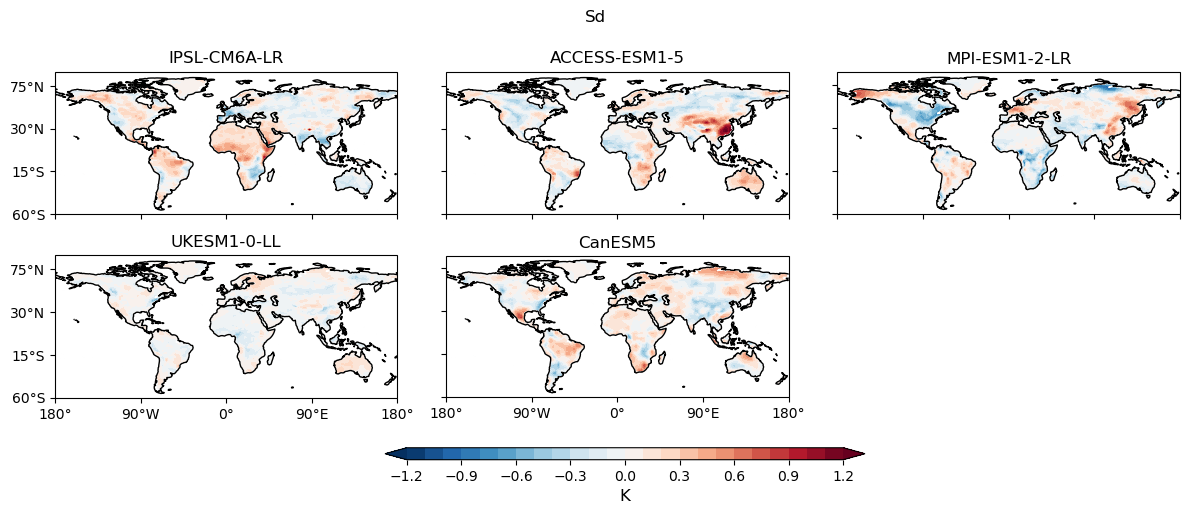

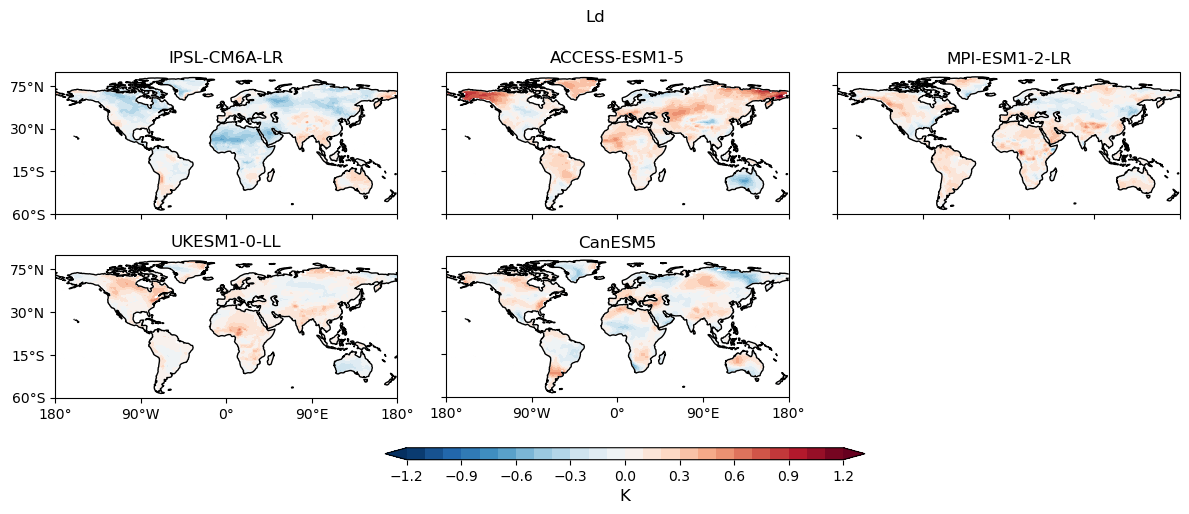

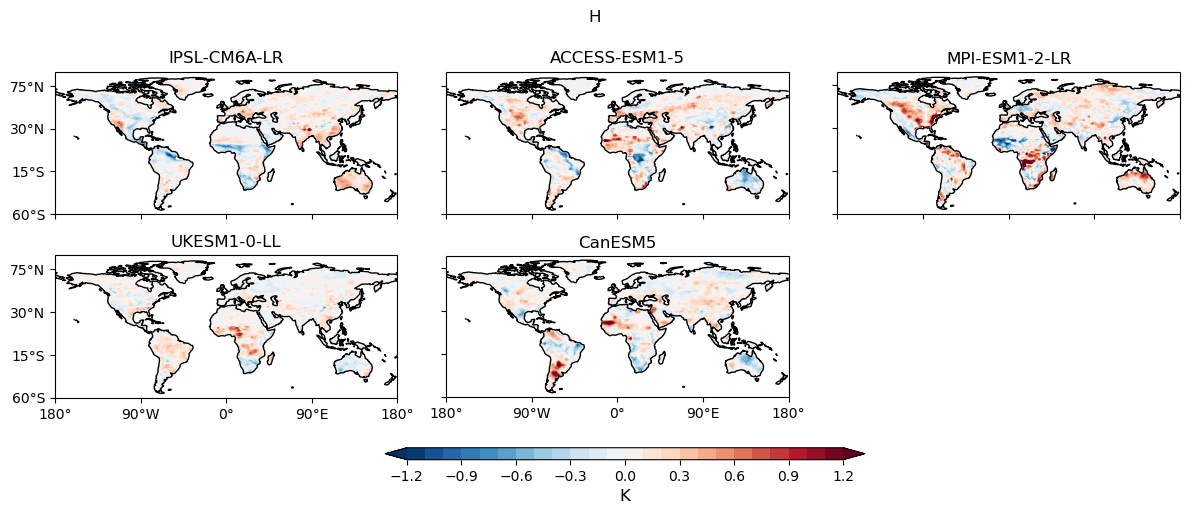

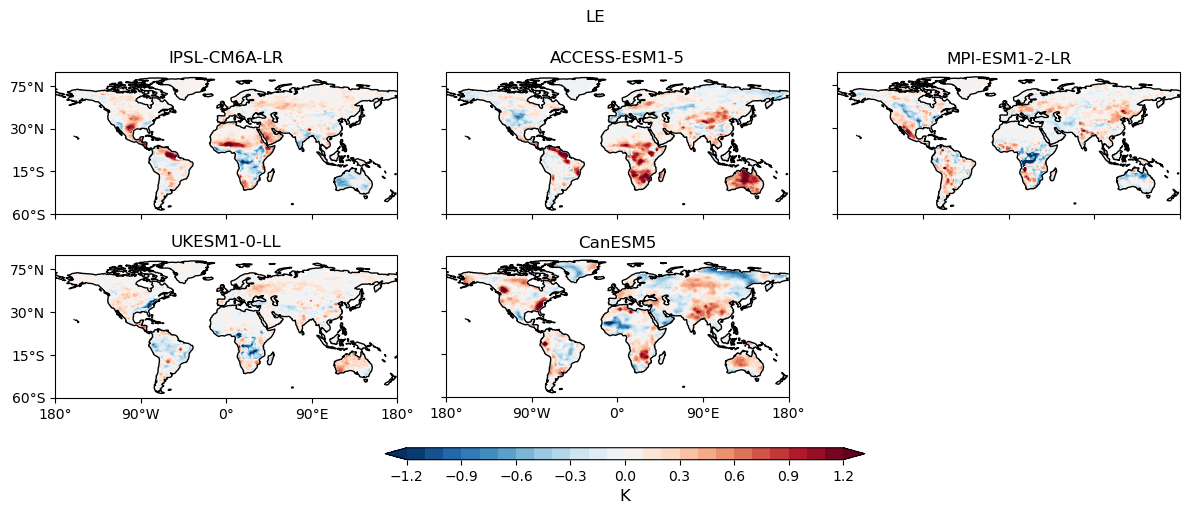

In [51]:
# Plot decomposition factors of SEB
    
cmap = "RdBu_r"
clevs = np.arange(-1.2,1.3,0.1)
width_inch = 12
height_inch = 6

for i,vv in enumerate(vars):
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.ravel()
    
    for mm in np.arange(len(models)):
        
        data = seb_effect_esm[mm][vv].sel(lat = slice(-60,90))
        map = axs[mm].contourf(data.lon, data.lat, data.values, clevs, transform = ccrs.PlateCarree(), cmap=cmap, extend = "both")
        axs[mm].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
        axs[mm].coastlines()

        # Longitude labels
        axs[mm].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[mm].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[mm].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[mm].yaxis.set_major_formatter(lat_formatter)

        # Titles
        axs[mm].set_title(models[mm])
        axs[mm].label_outer()

    for i in [5]:
        fig.delaxes(axs[i])
            
    
    fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

    cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
    cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.ax.set_xlabel("K", fontsize=12)

    fig.suptitle(vv, y = .85)
    fig.tight_layout()
    
    title = "SEB_" + vv + "_esm"
    # output_file = os.path.join(out_path, title) + ".png"
    # plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()
    plt.close()

### SEB components in regions of Afforestation 

In [35]:
%%capture

seb_aff_water_mean = []
seb_aff_energy_mean = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask

    masked = seb_effect_esm[m].where(mask)
    masked1 = seb_effect_esm[m].where(mask1)
    content = []; content1 = []
    for v in list(seb_effect_esm[m].data_vars)[:]:
        content.append(masked[v].weighted(cell_weight(masked)).mean(["lat","lon"]).data)
        content1.append(masked1[v].weighted(cell_weight(masked1)).mean(["lat","lon"]).data)
    content = np.array(content)
    content1 = np.array(content1)
    seb_aff_water_mean.append(content); 
    seb_aff_energy_mean.append(content1)
    
seb_aff_water_mean = pd.DataFrame(seb_aff_water_mean, columns = list(seb_effect_esm[m].data_vars)[:], index = models)
seb_aff_energy_mean = pd.DataFrame(seb_aff_energy_mean, columns = list(seb_effect_esm[m].data_vars)[:], index = models)

In [36]:
seb_aff_water_mean = pd.melt(seb_aff_water_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
seb_aff_water_mean["regime"] = "water-lim"

seb_aff_energy_mean = pd.melt(seb_aff_energy_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
seb_aff_energy_mean["regime"] = "energy-lim"

seb_aff = pd.concat([seb_aff_water_mean, seb_aff_energy_mean], axis = 0)
seb_aff_mean = seb_aff.groupby(['variable', 'models'])['value'].mean().reset_index()

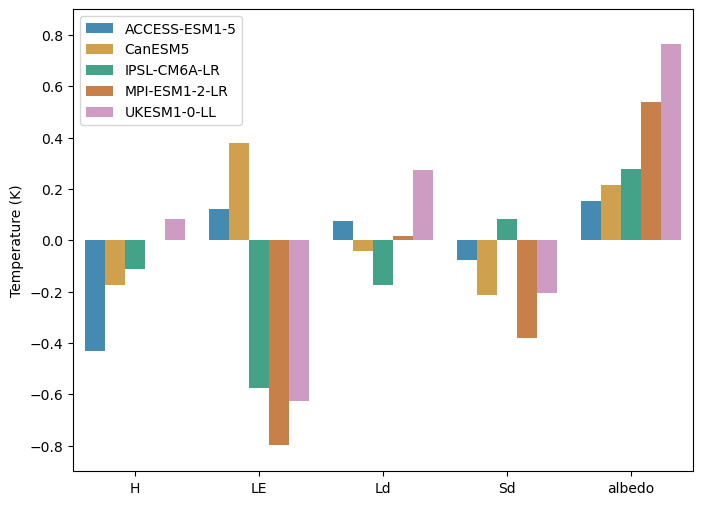

In [101]:

fig = plt.figure(figsize=(8, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=seb_aff_mean, hue = "models",# errorbar=("pi", 50),
        x="variable", y="value",
        palette="colorblind", alpha=.8, 
    )
# ax0.set_xticklabels(vars, rotation = 75)
ax0.set_ylim(-0.9, 0.9)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("Temperature (K)")
title = "SEB components in afforested regions (treeFrac>10%)"
# ax0.set_title(title)
output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

Contribution of original variables to SEB components

In [117]:
%%capture

delta_aff_mean = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask

    masked = xr_delta[m].where(mask)
    content = [];
    for v in ["rsds", "rlds", "hfls", "hfss", "albedo"]:
        content.append(masked[v].weighted(cell_weight(masked)).mean(["lat","lon"]).data)
    content = np.array(content)
    delta_aff_mean.append(content); 
    
delta_aff_mean = pd.DataFrame(delta_aff_mean, columns = ["rsds", "rlds", "hfls", "hfss", "albedo"], index = models)
delta_aff_mean.columns = ["Sd", "Ld", "LE", "H", "albedo"]
delta_aff_mean = pd.melt(delta_aff_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")

In [122]:
custom_order = ['H', 'LE', 'Ld', 'Sd']
delta_aff_mean = delta_aff_mean[delta_aff_mean['variable'].isin(custom_order)]
delta_aff_mean['variable'] = pd.Categorical(delta_aff_mean['variable'], categories=custom_order, ordered=True)
delta_aff_mean = delta_aff_mean.sort_values('variable')

C:\Users\mastr\AppData\Local\Temp\ipykernel_29008\1357102158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_aff_mean['variable'] = pd.Categorical(delta_aff_mean['variable'], categories=custom_order, ordered=True)


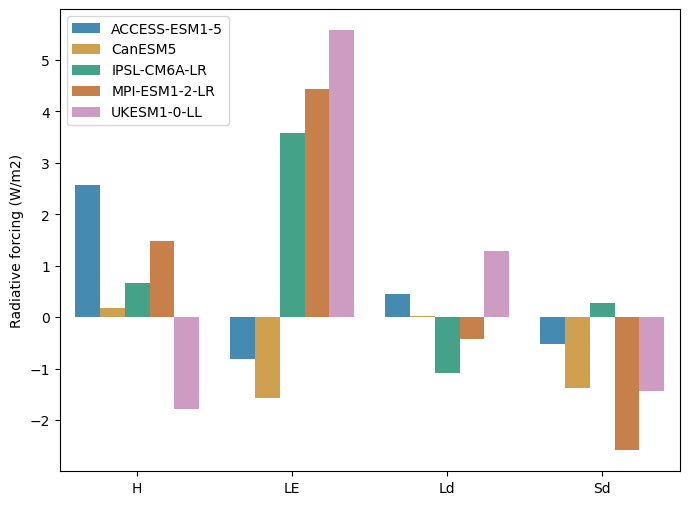

In [128]:

fig = plt.figure(figsize=(8, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=delta_aff_mean.sort_values("models"), hue = "models",# errorbar=("pi", 50),
        x="variable", y="value",
        palette="colorblind", alpha=.8, 
    )
# ax0.set_xticklabels(vars, rotation = 75)
# ax0.set_ylim(-0.9, 0.9)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("Radiative forcing (W/m2)")
# title = "SEB components in afforested regions (treeFrac>10%)"
# ax0.set_title(title)
output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

Text(0.45, 1.05, 'SEB components in afforested regions (treeFrac >10%)')

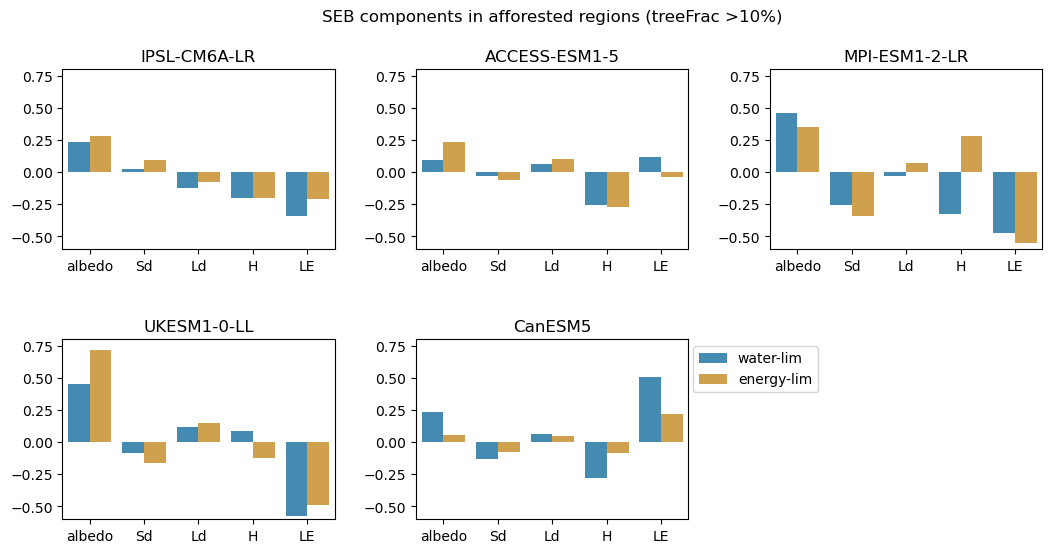

In [27]:
width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.barplot(
            data=seb_aff[seb_aff["models"] == models[m]], hue = "regime",# errorbar=("pi", 50),
            x="variable", y="value",
            palette="colorblind", alpha=.8,
        )
        # axs.set_xticklabels(regions, rotation = 75)
        axs.set_ylim(-0.6, 0.8)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.barplot(
            data=seb_aff[seb_aff["models"] == models[m]], hue = "regime",# errorbar=("pi", 50),
            x="variable", y="value",
            palette="colorblind", alpha=.8,
        )
        # axs.set_xticklabels(regions, rotation = 75)
        axs.set_ylim(-0.6, 0.8)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("SEB components in afforested regions (treeFrac >10%)", y =1.05, x = 0.45)

In [116]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]

df_seb_pos = []
df_seb_neg = []
for m,mm in enumerate(models):
    content = []
    content1 = []
    for bb,b in enumerate(boxes):
        masked = seb_effect_esm[m].where(mask)
        masked1 = seb_effect_esm[m].where(mask1)

        masked = seb_effect_esm[m].where(mask_treefrac_pos[m].notnull()).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3]))
        masked1 = seb_effect_esm[m].where(mask_treefrac_neg[m].notnull()).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3]))
        
        content.append(masked.mean().compute().to_array().to_dataframe(name = regions[bb]).drop(columns = ["height"]))
        content1.append(masked.mean().compute().to_array().to_dataframe(name = regions[bb]).drop(columns = ["height"]))
    content = pd.concat(content,axis = 1)
    content1 = pd.concat(content1,axis = 1)
    
    if hasattr(content, "plev"):
        content = content.drop(columns = ["plev"])
        content1 = content1.drop(columns = ["plev"])
    if hasattr(content, "type"):
        content = content.drop(columns = ["type"])
        content1 = content1.drop(columns = ["type"])
    
    content["model"] = models[m]
    content1["model"] = models[m]
    
    df_seb_pos.append(content)
    df_seb_neg.append(content1)

In [117]:
df_seb_pos = pd.concat(df_seb_pos, axis = 0)
df_seb_pos = pd.melt(df_seb_pos, ignore_index=False, id_vars="model", var_name="regions")

df_seb_neg = pd.concat(df_seb_neg, axis = 0)
df_seb_neg = pd.melt(df_seb_neg, ignore_index=False, id_vars="model", var_name="regions")

In [118]:
df_seb_pos = df_seb_pos.reset_index()
df_seb_neg = df_seb_neg.reset_index()

/tmp/ipykernel_2769665/3078695087.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(regions, rotation = 75)
/tmp/ipykernel_2769665/3078695087.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(regions, rotation = 75)
/tmp/ipykernel_2769665/3078695087.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(regions, rotation = 75)
/tmp/ipykernel_2769665/3078695087.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(regions, rotation = 75)
/tmp/ipykernel_2769665/3078695087.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(regions, rotation = 75)


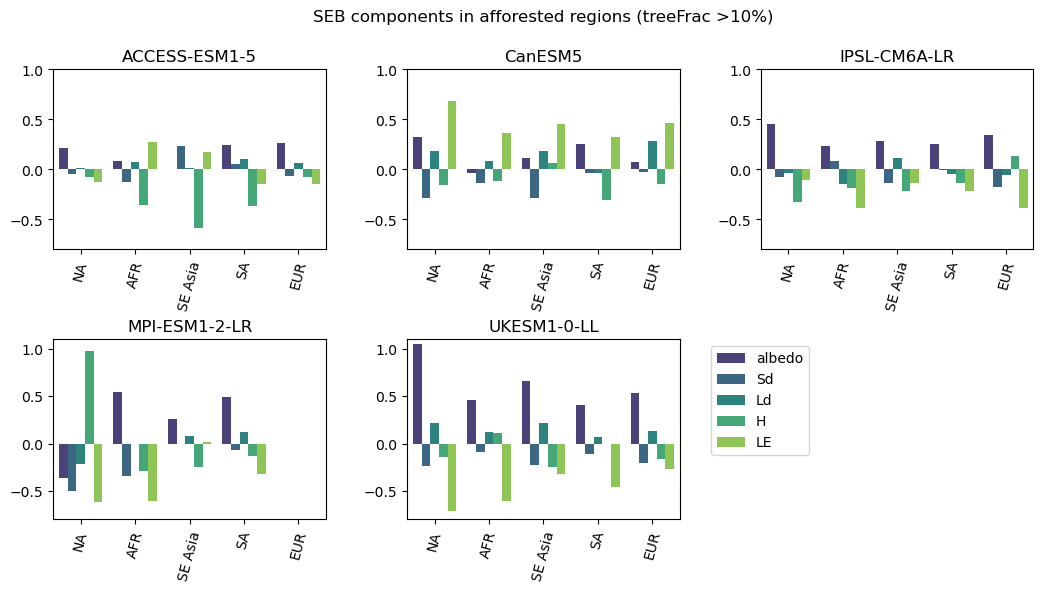

In [126]:
width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.barplot(
            data=df_seb_pos[df_seb_pos["model"] == models[m]], hue = df_seb_pos[df_seb_pos["model"] == models[m]]["variable"],# errorbar=("pi", 50),
            x="regions", y="value",
            palette="viridis", alpha=1,
        )
        axs.set_xticklabels(regions, rotation = 75)
        axs.set_ylim(-0.8, 1)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.barplot(
            data=df_seb_pos[df_seb_pos["model"] == models[m]], hue = df_seb_pos[df_seb_pos["model"] == models[m]]["variable"],# errorbar=("pi", 50),
            x="regions", y="value",
            palette="viridis", alpha=1, 
        )
        axs.set_xticklabels(regions, rotation = 75)
        axs.set_ylim(-0.8, 1.1)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
title = "SEB components in afforested regions (treeFrac >10%)"
fig.suptitle(title, y =1.05, x = 0.45)
output_file = os.path.join(out_path, title) + "_Regional.png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

## Intrinsic Biophysical Mechanism (IBPM) decomposition

Taking the difference between the biogeophysical variables of ssp370-ssp126 and ssp370 \
Compute the Surface Energy Balance Decomposition to estimate the contribution to temperature.

The SEB equation can be decomposed as follows:

\begin{equation}
\Delta T_{{s}} = \frac{\lambda_{0}}{1 + f} (\Delta R_{n} - \Delta G) + \frac{-\lambda_{0}}{(1 + f)^2} (R_{n} - G)\Delta f_{1} +\frac{-\lambda_{0}}{(1 + f)^2} (R_{n} - G)\Delta f_{2} + \Delta T_{a}
\end{equation}

where 
\begin{equation}
\lambda_{0} = \frac{1}{4 \sigma T_{a}^3},f = \frac{\rho C_{p}}{4 \sigma T_{a}^3 \gamma_{a}}(1+ \frac{1}{\beta}), \gamma_{a}=\rho C_{p} \frac{T_{s} - T_{a}}{H}
\end{equation}

In [18]:
# Define Stefan-Boltzmann Constant (Wm^-2K^-4)
# Define Emissivity Constant
# Define air density Constant (Kgm^-3) (dry air, 0°C, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6764509/)
# Define specific heat content (JKg^-1K^-1) (dry air, =0°C, https://pubs.aip.org/asa/jasa/article/76/2/555/669652/Variation-of-specific-heats-and-of-specific-heat)

sigma = 5.67*10**(-8)
eps = 0.97
rho = 1.2930
Cp = 1.0051*10**(-3) # it should be *10**(3), but in that case there is no correspondence with the modeled temperature, so we are considering (MJKg^-1K^-1)

In [19]:
# Equation Intrinsic Biophysical Mechanism (IBPM)

dT_ibpm_esm = []
dT_model_esm = []
ibpm_effect_esm = []

for i,mm in enumerate(models):
    ibpm_effects = xr.Dataset()
    
    xr_aff_seb = xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") # - xr_aff.sel(time = slice("2015-01","2015-12")).mean(dim = "time") 
    xr_ctl_seb = xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") # - xr_ctl.sel(time = slice("2015-01","2015-12")).mean(dim = "time") 
    
    lambda0 = 1/(4*sigma*xr_ctl_seb.tas**3)
    delta_Ta = xr_aff_seb.tas - xr_ctl_seb.tas
    gamma_ctl = (rho*Cp)*(xr_ctl_seb.ts - xr_ctl_seb.tas)/xr_ctl_seb.hfss
    gamma_aff = (rho*Cp)*(xr_aff_seb.ts - xr_aff_seb.tas)/xr_aff_seb.hfss
    
    Rn_aff = (xr_aff_seb.rsds - xr_aff_seb.rsus) + eps*xr_aff_seb.rlds - eps*sigma*xr_aff_seb.ts**(4)
    Rn_ctl = (xr_ctl_seb.rsds - xr_ctl_seb.rsus) + eps*xr_ctl_seb.rlds - eps*sigma*xr_ctl_seb.ts**(4)
    
    G_aff = Rn_aff - xr_aff_seb.hfss - xr_aff_seb.hfls
    G_ctl = Rn_ctl - xr_ctl_seb.hfss - xr_ctl_seb.hfls
    
    # gamma_ctl = (rho*Cp)*(xr_ctl_seb.ts - xr_ctl_seb.tas)/xr_ctl_seb.hfls
    # gamma_aff = (rho*Cp)*(xr_aff_seb.ts - xr_aff_seb.tas)/xr_aff_seb.hfls

    beta_ctl = xr_ctl_seb.hfss * xr_ctl_seb.hfls**(-1)
    beta_aff = xr_aff_seb.hfss * xr_aff_seb.hfls**(-1)

    delta_beta = beta_aff - beta_ctl
    delta_gamma = gamma_aff - gamma_ctl

    f = (rho*Cp)*lambda0*gamma_ctl**(-1)*(1+1/beta_ctl)

    delta_Rn = Rn_aff - Rn_ctl
    delta_G = G_aff - G_ctl
    # delta_Ta = xr_aff_seb.tas - xr_ctl_seb.tas

    delta_f1 = -f * (delta_gamma)*gamma_ctl**(-1)
    delta_f2 = -(rho*Cp) * lambda0 * (delta_beta)*beta_ctl**(-2)
    
    dT_model = (xr_aff_seb.ts - xr_ctl_seb.ts)

    dT_ibpm = lambda0*(1+f)**(-1) * (delta_Rn - delta_G) + -lambda0*(1+f)**(-2)*(Rn_ctl - G_ctl)*delta_f1 + -lambda0*(1+f)**(-2)*(Rn_ctl - G_ctl)*delta_f2 + delta_Ta
    
    ibpm_effects["RF"] = lambda0*(1+f)**(-1) * (delta_Rn - delta_G)
    ibpm_effects["AerodRes"] = -lambda0*(1+f)**(-2)*(Rn_ctl - G_ctl)*delta_f1
    ibpm_effects["BowenRatio"] = -lambda0*(1+f)**(-2)*(Rn_ctl - G_ctl)*delta_f2
    ibpm_effects["AtmFeed"] = delta_Ta
    
    dT_model_esm.append(dT_model)
    dT_ibpm_esm.append(dT_ibpm)
    ibpm_effect_esm.append(ibpm_effects)

C:\Users\mastr\AppData\Local\Temp\ipykernel_23124\1538167045.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


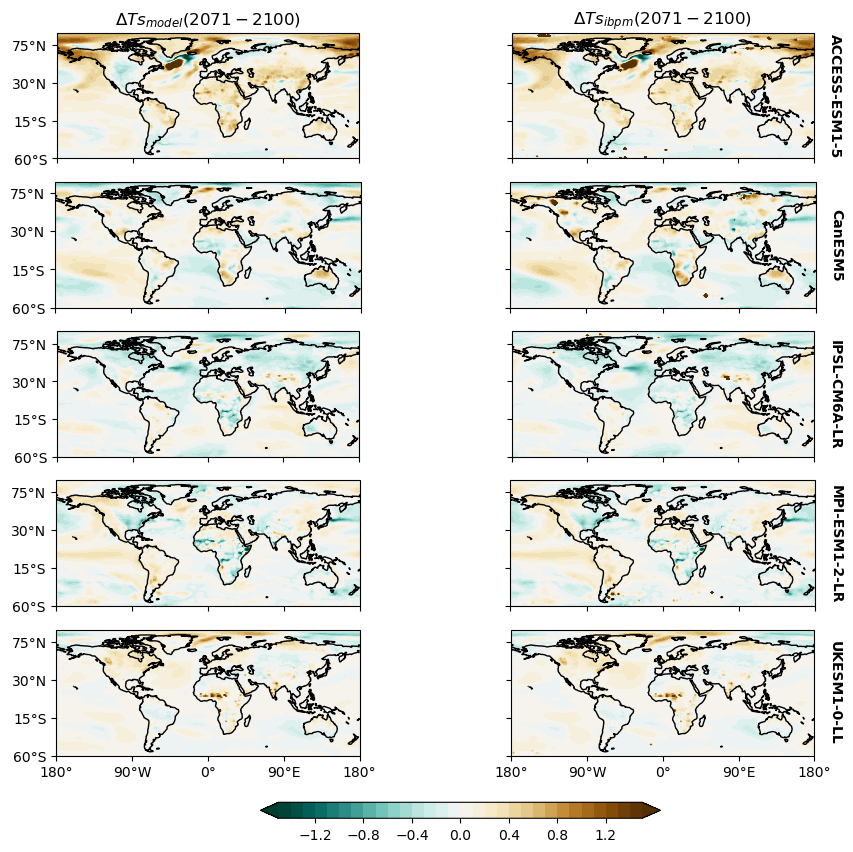

In [113]:

to_plot = [dT_model_esm[0], dT_ibpm_esm[0], dT_model_esm[1], dT_ibpm_esm[1], dT_model_esm[2], dT_ibpm_esm[2], dT_model_esm[3], dT_ibpm_esm[3], dT_model_esm[4], dT_ibpm_esm[4]]

cmap = "BrBG_r"
clevs=np.arange(-1.5,1.6,0.1)

# Create the figure 
width_inch = 10
height_inch = 8

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.ravel()

for i, ax in enumerate(to_plot):
    
    # Add the cyclic point
    data = to_plot[i].sel(lat = slice(-60,90))
    data0,lons=add_cyclic_point(data,coord=data['lon'])
       
    map = axs[i].contourf(lons, data.lat, data0, clevs, transform = ccrs.PlateCarree(), cmap=cmap, extend='both')
    axs[i].coastlines()

    # if i == 0:
    #     hatch = xr_mw_ts[i]
    #     sign = np.ma.masked_greater(hatch, 0.1)
    #     map1 = axs[i].pcolor(lons, data.lat, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha=0)
    # if i ==2 or i == 4 or i == 6:
    #     hatch = xr_mw_ts[np.int32(i/2)]
    #     sign = np.ma.masked_greater(hatch, 0.1)
    #     map1 = axs[i].pcolor(lons, data.lat, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha=0)        
    # else: None
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)    
    
    axs[0].set_title("$\Delta Ts_{model} (2071-2100)$")
    axs[1].set_title("$\Delta Ts_{ibpm} (2071-2100)$")
    
    if i%2 != 0: 
        idx = int((i/2)-0.5)
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel(models[idx], labelpad = 20, rotation = -90, weight='bold')
    
    axs[i].label_outer()

cb_ax = fig.add_axes([0.325, -0.03, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.1)

fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()

title = "IBPM_Ts_esm"
output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

#### Disentangle the different contributions of IBPM

In [55]:
vars = ["RF", "AerodRes", "BowenRatio", "AtmFeed"]

/tmp/ipykernel_823077/2534520066.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


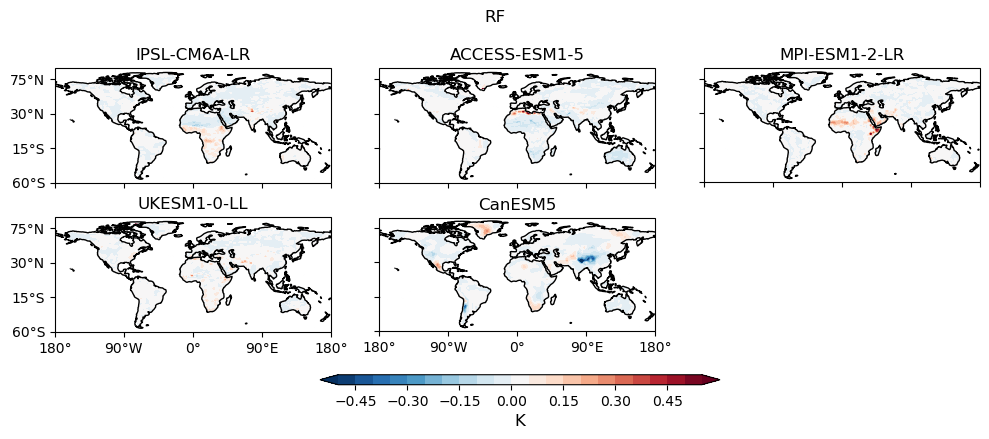

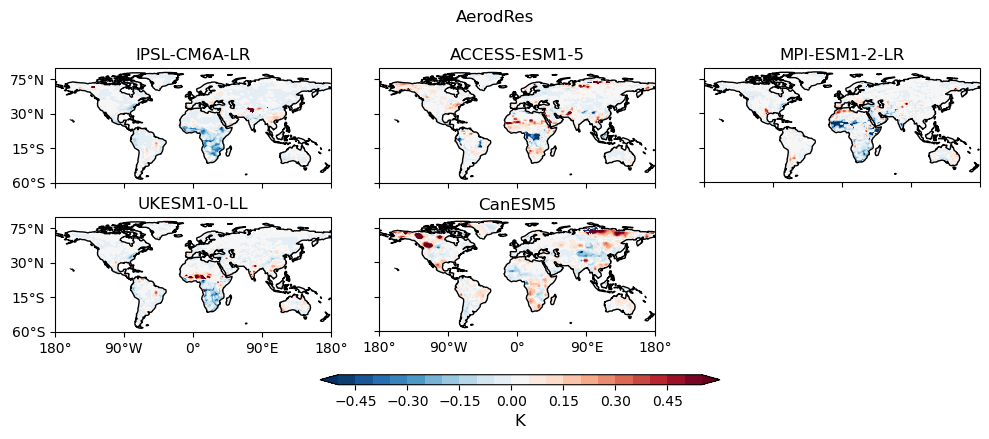

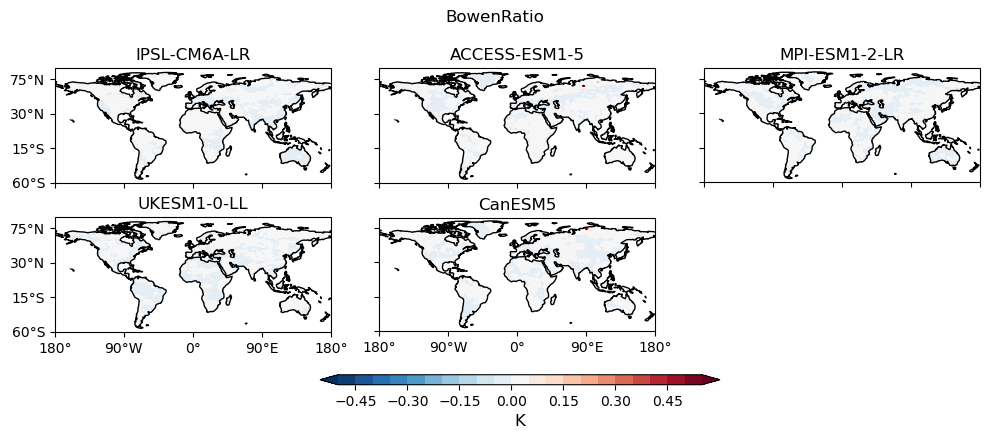

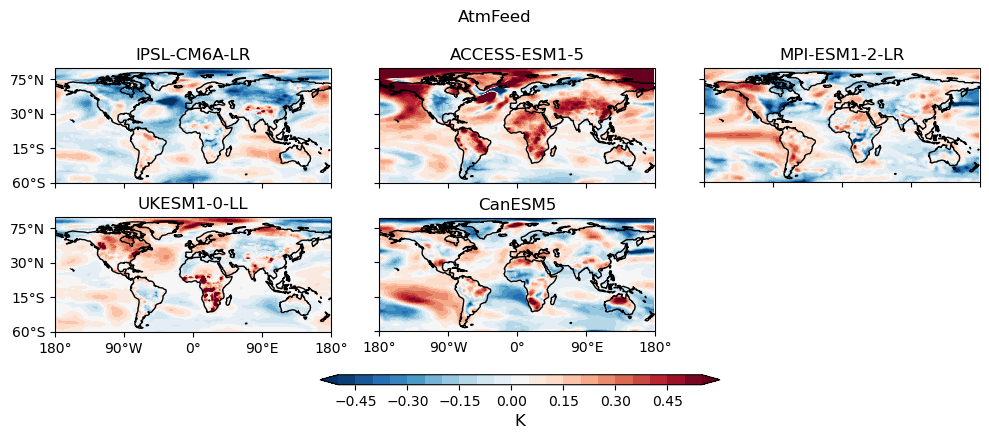

In [65]:
cmap = "RdBu_r"
clevs = np.arange(-0.5,0.6,0.05)
width_inch = 10
height_inch = 5

for i,vv in enumerate(vars):
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.ravel()
    
    for mm in np.arange(len(models)):
        
        data = ibpm_effect_esm[mm][vv]
        map = axs[mm].contourf(data.lon, data.lat, data.values, clevs, transform = ccrs.PlateCarree(), cmap=cmap, extend = "both")
        if vv != "AtmFeed":
            axs[mm].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
        axs[mm].coastlines()

        # Longitude labels
        axs[mm].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[mm].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[mm].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[mm].yaxis.set_major_formatter(lat_formatter)

        # Titles
        axs[mm].set_title(models[mm])
        axs[mm].label_outer()
        
    for i in [5]:
        fig.delaxes(axs[i])
            
    
    fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

    cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
    cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.ax.set_xlabel("K", fontsize=12)

    fig.suptitle(vv, y = .85)
    fig.tight_layout()
    
    title = "IBPM_" + vv + "_esm"
    output_file = os.path.join(out_path, title) + ".png"
    plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()
    plt.close()

#### IBPM components in regions of Afforestation

In [22]:
ibpm_aff_water_mean = []
ibpm_aff_energy_mean = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull() & np.ma.masked_less(xr_mw_ts[m], 0.1).mask

    masked = ibpm_effect_esm[m].where(mask)
    masked1 = ibpm_effect_esm[m].where(mask1)
    content = []; content1 = []
    for v in list(ibpm_effect_esm[m].data_vars)[:]:
        content.append(masked[v].weighted(cell_weight(masked)).mean(["lat","lon"]).data)
        content1.append(masked1[v].weighted(cell_weight(masked1)).mean(["lat","lon"]).data)
    content = np.array(content)
    content1 = np.array(content1)
    ibpm_aff_water_mean.append(content); 
    ibpm_aff_energy_mean.append(content1);
    
ibpm_aff_water_mean = pd.DataFrame(ibpm_aff_water_mean, columns = list(ibpm_effect_esm[m].data_vars)[:], index = models)
ibpm_aff_energy_mean = pd.DataFrame(ibpm_aff_energy_mean, columns = list(ibpm_effect_esm[m].data_vars)[:], index = models)

In [23]:
ibpm_aff_water_mean = pd.melt(ibpm_aff_water_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
ibpm_aff_water_mean["regime"] = "water-lim"

ibpm_aff_energy_mean = pd.melt(ibpm_aff_energy_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
ibpm_aff_energy_mean["regime"] = "energy-lim"

ibpm_aff = pd.concat([ibpm_aff_water_mean, ibpm_aff_energy_mean], axis = 0)
ibpm_aff_mean = ibpm_aff.groupby(['variable', 'models'])['value'].mean().reset_index()

variable         models     value
0  AerodRes  ACCESS-ESM1-5 -0.497721
1  AerodRes        CanESM5 -0.085263
2  AerodRes   IPSL-CM6A-LR -0.284909
3  AerodRes  MPI-ESM1-2-LR -0.328627
4  AerodRes    UKESM1-0-LL -0.210910
5   AtmFeed  ACCESS-ESM1-5  0.362234
6   AtmFeed        CanESM5 -0.220879
7   AtmFeed   IPSL-CM6A-LR -0.173644
8   AtmFeed  MPI-ESM1-2-LR -0.216279
9   AtmFeed    UKESM1-0-LL  0.565267

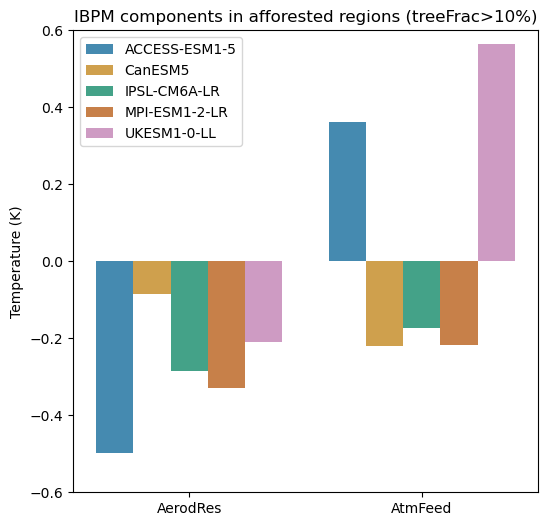

In [32]:
import seaborn as sns

fig = plt.figure(figsize=(6, 6))

ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=ibpm_aff_mean[ibpm_aff_mean['variable'].isin(["AerodRes", "AtmFeed"])], hue = "models",# errorbar=("pi", 50),
        x="variable", y="value",
        palette="colorblind", alpha=.8, 
    )
# ax0.set_xticklabels(vars, rotation = 75)
ax0.set_ylim(-0.8, 0.8)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("Temperature (K)")
title = "IBPM components in afforested regions (treeFrac>10%)"
ax0.set_title(title)
output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

## Plot SEB & IBPM in 2 panels

In [57]:
toplot = pd.concat([seb_aff_mean, ibpm_aff_mean], axis = 0)
toplot = toplot[~toplot["variable"].isin(["RF", "BowenRatio"])]

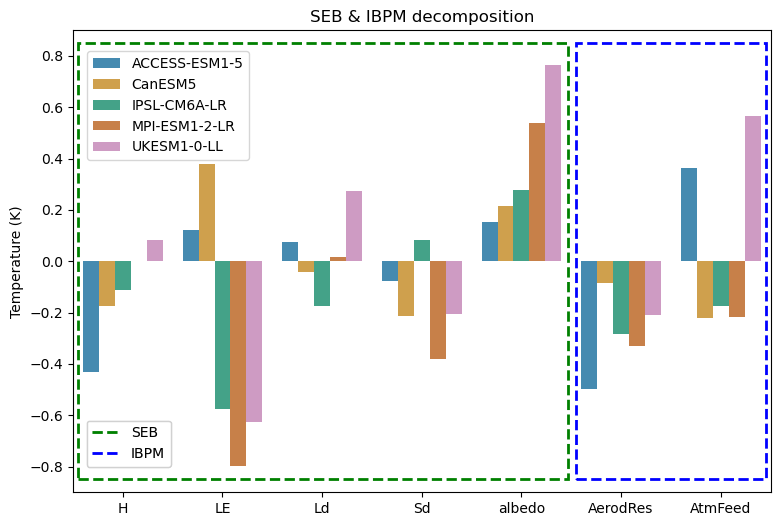

In [111]:
import matplotlib.patches as patches
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(9, 6))
ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
        data=toplot, hue = "models",# errorbar=("pi", 50),
        x="variable", y="value",
        palette="colorblind", alpha=.8, 
    )
# ax0.set_xticklabels(vars, rotation = 75)
ax0.set_ylim(-0.9, 0.9)
ax0.set_xlabel("",)
ax0.set_ylabel("Temperature (K)")
title = "SEB & IBPM decomposition"
ax0.set_title(title)

# Coordinates for rectangles
first_group_indices = [0, 1, 2, 3, 4]
second_group_indices = [5, 6]

# Get the positions and width of bars
positions = ax0.get_xticks()
width = (positions[1] - positions[0]) * 0.9  # Approximate width of each bar

# Draw green dotted square around the first 4 variables
rect1 = patches.Rectangle(
    (positions[first_group_indices[0]] - width/2, -0.85),
    width * len(first_group_indices)+0.42,
    1.7,
    linewidth=2,
    edgecolor='green',
    linestyle='--',
    facecolor='none'
)
ax0.add_patch(rect1)

# Draw blue dotted square around the last 2 variables
rect2 = patches.Rectangle(
    (positions[second_group_indices[0]] - width/2, -0.85),
    width * len(second_group_indices)+0.1,
    1.7,
    linewidth=2,
    edgecolor='blue',
    linestyle='--',
    facecolor='none'
)
ax0.add_patch(rect2)

ax0.legend(loc='upper left', bbox_to_anchor=(0.01, 0.97), fontsize = 10)
legend1 = ax0.get_legend()

# Custom legend
custom_lines = [
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='SEB'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='IBPM')
]

# Adding a second legend for the custom lines
legend1plus = ax0.legend(handles=custom_lines, loc='upper right', bbox_to_anchor=(0.15, 0.17), fontsize=10)

ax0.add_artist(legend1)
ax0.add_artist(legend1plus)

output_file = os.path.join(out_path, title) + ".png"

plt.show()
plt.close()

## Two Resistance Mechanism (TRM) decomposition

Taking the difference between the biogeophysical variables of ssp370-ssp126 and ssp370 \
Compute the Surface Energy Balance Decomposition to estimate the contribution to temperature.

The SEB equation can be decomposed as follows:



\begin{equation}
\Delta T_{{s}} = \frac{dT_{s}}{d\alpha} \Delta \alpha + \frac{dT_{s}}{d\varepsilon} \Delta \varepsilon + \frac{dT_{s}}{dG} \Delta G + \frac{dT_{s}}{dr_{a}} \Delta r_{a} + \frac{dT_{s}}{dr_{s}} \Delta r_{s} + \Delta T_{a}\end{equation}

where 
\begin{equation}
\lambda_{0} = \frac{1}{4 \sigma T_{a}^3} \end{equation}

\begin{equation}
f = \frac{r_{0}}{r_{a}}[1+ \frac{\delta}{\gamma}(\frac{r_{a}}{r_{a} + r_{s}})]
\end{equation}


\begin{equation}
r_{0} = \rho C_{p} \lambda_{0}
\end{equation}


\begin{equation}
r_{a}=\rho C_{p} \frac{T_{s} - T_{a}}{H}
\end{equation}

\begin{equation}
r_{s}=\frac{\rho L_{v}[q_{s}(T_{s}) - q_{a}]}{LE} - r_{a}
\end{equation}

In [9]:
# Define Stefan-Boltzmann Constant (Wm^-2K^-4)
# Define Emissivity Constant
# Define air density Constant (Kgm^-3) (dry air, 0°C, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6764509/)
# Define specific heat content (JKg^-1K^-1) (dry air, =0°C, https://pubs.aip.org/asa/jasa/article/76/2/555/669652/Variation-of-specific-heats-and-of-specific-heat)
# Define Latent heat of vaporization (JKg^-1) (https://link.springer.com/referenceworkentry/10.1007/978-90-481-2642-2_327)
# Define ratio of the gas constants of dry air and water vapour (epsilon)

sigma = 5.67*10**(-8)
eps = 0.97
rho = 1.2930
Cp = 1.0051**(-3)
Lv = 2.260**(-3)
epsilon = 0.622

In [10]:
# Convert °K to °C for computing the Saturation vapor pressure 

for i,item in enumerate(xr_aff):
    xr_aff[i]["tas"] = xr_aff[i].tas - 273.15
    xr_ctl[i]["tas"] = xr_ctl[i].tas - 273.15

    xr_aff[i]["ts"] = xr_aff[i].ts - 273.15
    xr_ctl[i]["ts"] = xr_ctl[i].ts - 273.15

In [83]:
# Equation Two Resistance Mechanism (IBPM)

dT_trm_esm = []
dT_model_esm = []
trm_effect_esm = []

for i,item in enumerate(xr_aff):
    
    xr_aff_seb = xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") # - xr_aff.sel(time = slice("2015-01","2015-12")).mean(dim = "time") 
    xr_ctl_seb = xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") # - xr_ctl_seb.sel(time = slice("2015-01","2015-12")).mean(dim = "time") 
    
    lambda0 = 1/(4*sigma*xr_ctl_seb.tas**3)
    
    # Aerodynamic resistance
    ra_ctl = (rho*Cp)*(xr_ctl_seb.ts - xr_ctl_seb.tas)/xr_ctl_seb.hfss; ra_ctl = ra_ctl.where(ra_ctl>=0, 0)
    ra_aff = (rho*Cp)*(xr_aff_seb.ts - xr_aff_seb.tas)/xr_aff_seb.hfss; ra_aff = ra_aff.where(ra_aff>=0, 0)
    
    r0 = rho*Cp*lambda0
    gamma = Cp*xr_ctl_seb.ps * (epsilon*Lv)**-1
    
    # Saturated specific humidity at Ts
    # calculated from Saturation vapor pressure from Monteith & Unsworth (2008)
    es_aff = (0.61078**(17.27*(xr_aff_seb.ts)/(xr_aff_seb.ts+237.3)))* 1e3    # from kPa to Pa
    es_ctl = (0.61078**(17.27*(xr_ctl_seb.ts)/(xr_ctl_seb.ts+237.3)))* 1e3    # from kPa to Pa
    qs_aff = epsilon*es_aff/(xr_aff_seb.ps-(1-epsilon)*es_aff)    
    qs_ctl = epsilon*es_ctl/(xr_ctl_seb.ps-(1-epsilon)*es_ctl)    
    
    # Saturated specific humidity at Ta (tas)
    es_ta_ctl = (0.61078**(17.27*(xr_ctl_seb.tas)/(xr_ctl_seb.tas+237.3)))* 1e3    # from kPa to Pa
    qa_ctl = epsilon*es_ta_ctl/(xr_ctl_seb.ps-(1-epsilon)*es_ta_ctl)    
    
    # Surface resistance
    rs_aff = ((rho*Lv)*(qs_aff - xr_aff_seb.huss)*xr_aff_seb.hfls**(-1)) - ra_aff; rs_aff = rs_aff.where(ra_aff>=0, 0)
    rs_ctl = ((rho*Lv)*(qs_ctl - xr_ctl_seb.huss)*xr_ctl_seb.hfls**(-1)) - ra_ctl; rs_ctl = rs_ctl.where(rs_ctl>=0, 0)
    
    # Energy redistribution factor
    delta = (es_aff - es_ctl)/(xr_aff_seb.tas - xr_ctl_seb.tas)
    f = r0/ra_ctl*(1 + delta/gamma *(ra_ctl*(ra_ctl + rs_ctl)))
    
    # Here Radiation is computed as Rn*. considering tas rather than ts
    Rn_aff = (xr_aff_seb.rsds - xr_aff_seb.rsus) + eps*xr_aff_seb.rlds - eps*sigma*xr_aff_seb.tas**(4)
    Rn_ctl = (xr_ctl_seb.rsds - xr_ctl_seb.rsus) + eps*xr_ctl_seb.rlds - eps*sigma*xr_ctl_seb.tas**(4)
    
    G_aff = (xr_aff_seb.rsds - xr_aff_seb.rsus) + eps*xr_aff_seb.rlds - eps*sigma*xr_aff_seb.ts**(4) - xr_aff_seb.hfss - xr_aff_seb.hfls
    G_ctl = (xr_ctl_seb.rsds - xr_ctl_seb.rsus) + eps*xr_ctl_seb.rlds - eps*sigma*xr_ctl_seb.ts**(4) - xr_ctl_seb.hfss - xr_ctl_seb.hfls
       
    # First derivatives
    dTs_albedo = -lambda0*xr_aff_seb.rsds/(1+f)
    dTs_G = -lambda0/(1+f)
    dTs_Rn = lambda0/(1+f)
    
    first_term = lambda0*rho*Lv*(qa_ctl - xr_ctl_seb.huss) * 1/(ra_ctl+rs_ctl)**2 * 1/(1+f)
    second_term = (Rn_ctl-G_ctl - (rho*Lv*(qa_ctl - xr_ctl_seb.huss) * 1/(ra_ctl+rs_ctl))) * 1/(1+f)**2
    
    dTs_ra = first_term + lambda0 * second_term * r0/ra_ctl**2 * (1+delta/gamma*(ra_ctl*1/(ra_ctl+rs_ctl))**2)
    dTs_rs = first_term + lambda0 * second_term * (delta/gamma*(ra_ctl*1/(ra_ctl+rs_ctl)**2))
    
    # Delta parameters
    delta_albedo = (xr_aff_seb.rsus/xr_aff_seb.rsds) - (xr_ctl_seb.rsus/xr_ctl_seb.rsds)
    delta_G = G_aff - G_ctl
    delta_Rn = Rn_aff - Rn_ctl
    delta_ra = ra_aff - ra_ctl
    delta_rs = rs_aff - rs_ctl
    delta_Ta = xr_aff_seb.tas - xr_ctl_seb.tas
    
    dT_model = (xr_aff_seb.ts - xr_ctl_seb.ts)

    dT_trm = dTs_Rn*delta_Rn + dTs_ra*delta_ra + dTs_rs*delta_rs + delta_Ta  #dTs_albedo*delta_albedo + dTs_G*delta_G
    
    trm_effects = [dTs_Rn*delta_Rn,
                    dTs_ra*delta_ra,
                    dTs_rs*delta_rs,
                    delta_Ta]
    
    dT_model_esm.append(dT_model)
    dT_trm_esm.append(dT_trm)
    trm_effect_esm.append(trm_effects)

KeyboardInterrupt: 

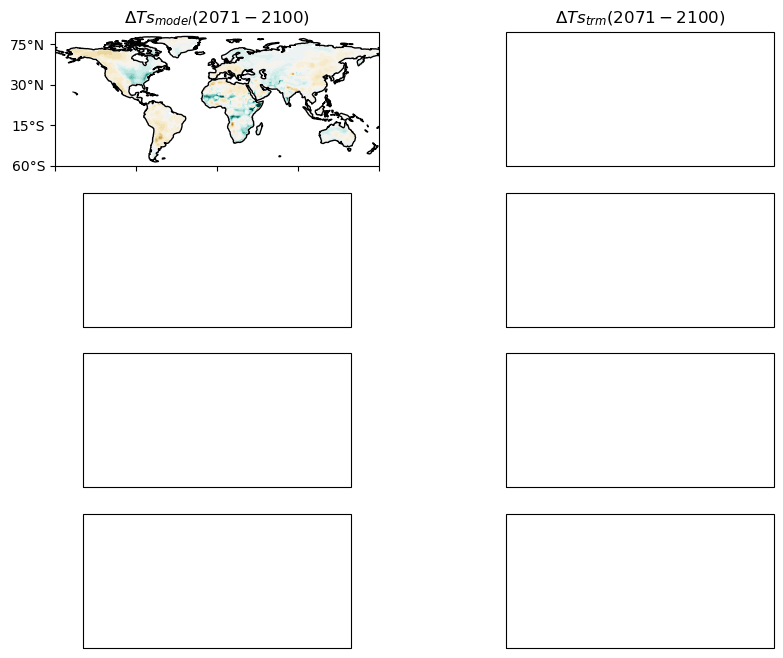

In [33]:
to_plot = [dT_model_esm[0], dT_trm_esm[0], dT_model_esm[1], dT_trm_esm[1], dT_model_esm[2], dT_trm_esm[2], dT_model_esm[3], dT_trm_esm[3]]

cmap = "BrBG_r"
clevs=np.arange(-1.5,1.6,0.1)

# Create the figure 
width_inch = 10
height_inch = 8

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.ravel()

for i, ax in enumerate(to_plot):
    
    # Add the cyclic point
    data = to_plot[i]
    data0,lons=add_cyclic_point(data,coord=data['lon'])
    
    map = axs[i].contourf(lons, data.lat, data0, clevs, transform = ccrs.PlateCarree(), cmap=cmap, extend='both')
    axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)    
    
    axs[0].set_title("$\Delta Ts_{model} (2071-2100)$")
    axs[1].set_title("$\Delta Ts_{trm} (2071-2100)$")
    
    if i%2 != 0: 
        idx = int((i/2)-0.5)
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel(models[idx], labelpad = 20, rotation = -90, weight='bold')
    
    axs[i].label_outer()
    
cb_ax = fig.add_axes([0.325, -0.03, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.1)

fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()

title = "TRM_Ts_esm"
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()

### Disentangle the different contributions of TRM

In [85]:
vars = ["RF", "Aerod. Resistance", "Surface Resistance", "Atmos. feedbacks"]

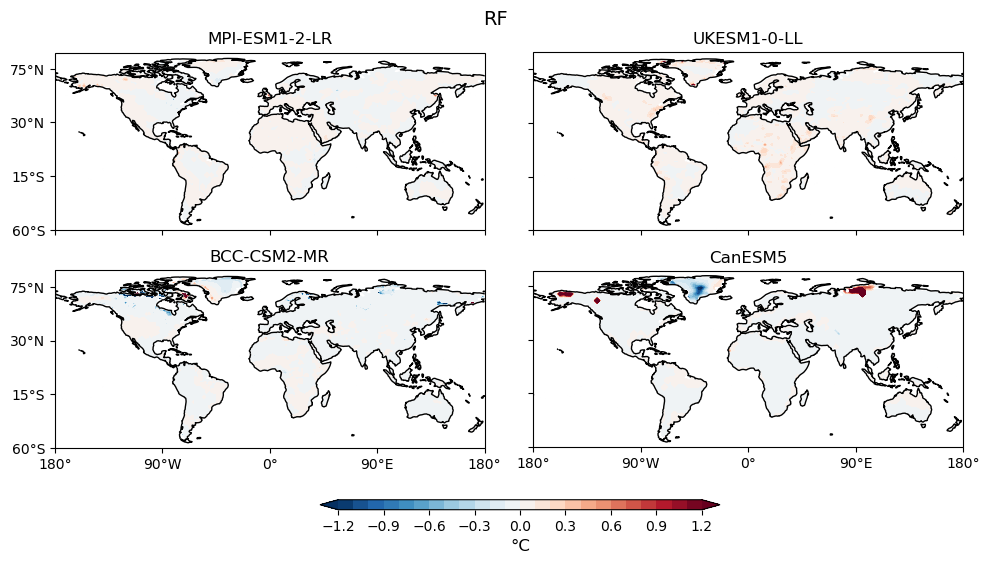

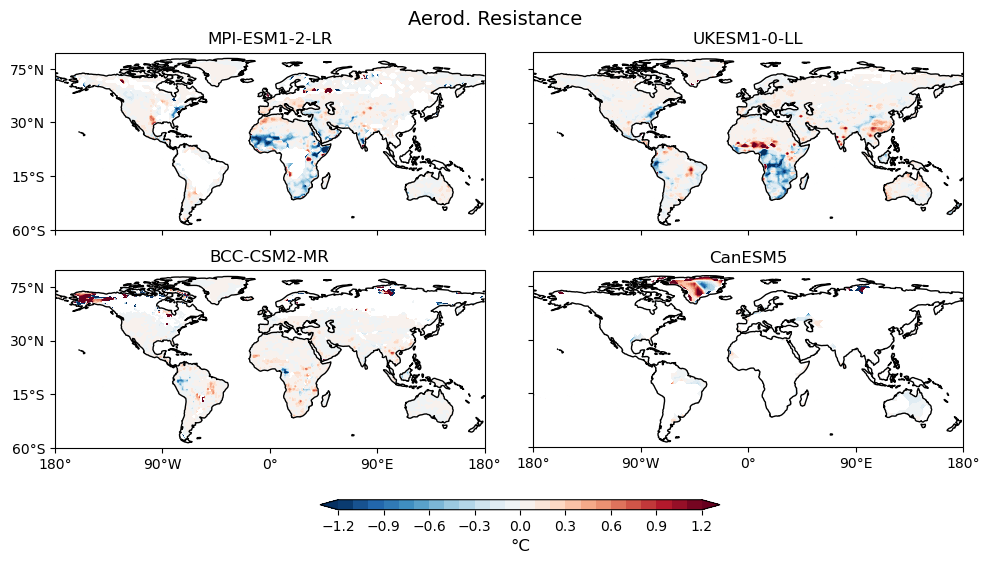

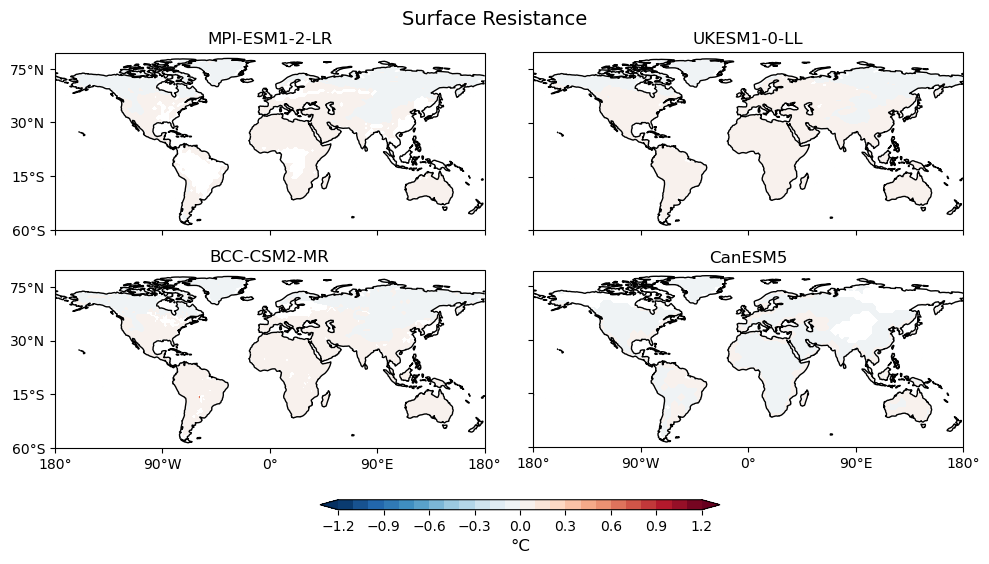

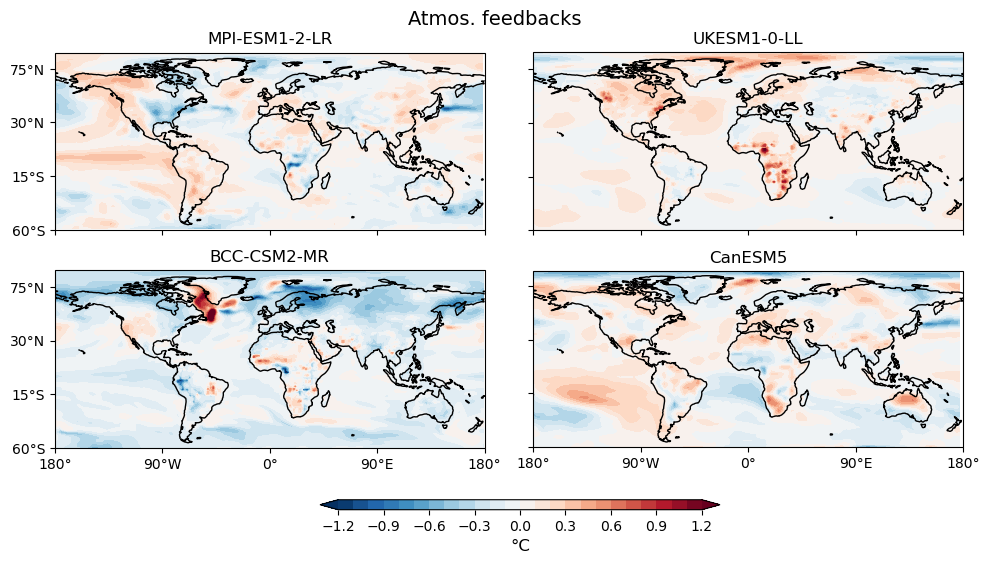

In [87]:
cmap = "RdBu_r"
clevs = np.arange(-1.2,1.3,0.1)
width_inch = 10
height_inch = 5

for i,vv in enumerate(vars):
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.ravel()
    
    for mm in np.arange(len(models)):
        
        data = trm_effect_esm[mm][i].sel(lat = slice(-60,90))
        map = axs[mm].contourf(data.lon, data.lat, data.values, clevs, transform = ccrs.PlateCarree(), cmap=cmap, extend = "both")
        if vv != "Atmos. feedbacks":
            axs[mm].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
        axs[mm].coastlines()

        # Longitude labels
        axs[mm].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[mm].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[mm].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[mm].yaxis.set_major_formatter(lat_formatter)

        # Titles
        axs[mm].set_title(models[mm])
        axs[mm].label_outer()
    
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.8, wspace=0.1, hspace=0.15)
    fig.suptitle(vv, y =.95, size = 14)
    fig.tight_layout()
    
    cb_ax = fig.add_axes([0.325, -0.05, 0.4, 0.02])
    cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.ax.set_xlabel("°C", fontsize=12)
    
    title = "TRM_" + vv + "_esm"
    output_file = os.path.join(out_path, title) + ".png"
    plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()
    plt.close()

TO DO:

APPLY TRM MECHANISM DECOMPOSITION AND COMPUTE dTs/dLAI \
plot of zonal mean values for the models and the factors examined\
results by regions\
results by season

PERSPECTIVES:

Define the changes relative to the historical period: (ssp126Lu - sssp370)/(ssp370 - hist) \
Afforestation scenario like ssp126 but instead of BECCS put forest (ssp126aff)\
test ssp370-ssp126aff vs ssp126-ssp126aff: what is the effectivenes of this LUC mitigation on different RF?\
Compute checkerboard simulations for estimating local and non-local effects or use IBPM decomposition with atmos feedbacks?\
Is there any global for which ssp126aff is more effective?\
precipitation? moisture convergence/divergence/thermodynamic vs dynamic changes?
